In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1
DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 1
EPOCH =50

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
GEN_ACT = "hardtanh"
DIS_ACT = "sigmoid"

### Optimizer Settings

In [8]:
GEN_OPTIM_NAME = "adabelief"
GEN_init_lr = 2e-4
GEN_momentum = 0.9

In [9]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 3e-4
DIS_momentum = 0.9

# Epochs

In [10]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss

In [11]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [12]:
def train_a2b_epoch(generator, gen_optimizer, discriminator, dis_optimizer, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.train().to(device)
    discriminator = discriminator.train().to(device)

    dis_l = 0
    gen_l = 0
    ssim_l = 0
    mae_l = 0
    air_l = 0
    bone_l = 0
    perceptual_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        _gen = nn.BCELoss()(y_pr_cls.float(), torch.ones(y_pr_cls.size(), dtype=torch.float, device=device))
        _dis = nn.BCELoss()(y_cls.float(), torch.ones(y_cls.size(), dtype=torch.float, device=device)) + \
                                nn.BCELoss()(y_pr_cls.float(), torch.zeros(y_pr_cls.size(), dtype=torch.float, device=device))

        dis_optimizer.zero_grad()
        gen_optimizer.zero_grad()
        
        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        air_loss = nn.BCELoss(reduction="none")(air_pr.float(), air_x.float())
        air_loss = torch.where(air_x == 1, air_loss, air_loss * 10.0)
        air_loss = air_loss.mean()
        
        _loss = _gen + air_loss + _mae + _ssim + _dis
        _loss.backward()    
        gen_optimizer.step()
        dis_optimizer.step()

        dis_l += _gen.item()
        gen_l += _dis.item()
        air_l += air_loss.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()
        
    return  mae_l/(index+1), ssim_l/(index+1), air_l/(index+1), gen_l/(index+1), dis_l/(index+1)

In [13]:
@torch.no_grad()
def eval_epoch(generator, discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    discriminator = discriminator.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    air_ = []
    bone_ = []
    acc_ = []
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        y_cls = discriminator(y)
        y_cls = Activation(name=DIS_ACT)(y_cls)
        y_pr_cls = discriminator(y_pr)
        y_pr_cls = Activation(name=DIS_ACT)(y_pr_cls)
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]
        
        # adversarial
        acc = Accuracy()(y_cls, torch.ones(y_cls.size(), device=y_cls.device))
        acc_ += [acc.item()]
        acc = Accuracy()(y_pr_cls, torch.zeros(y_pr_cls.size(), device=y_pr_cls.device))
        acc_ += [acc.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(acc_)/len(acc_)

In [14]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        _min = -500
        _max = 500
        upper = ((_min+1) - (_min))/(_max-(_min))
        lower = ((_min) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        
        upper = ((256) - (_min))/(_max-(_min))
        lower = ((255) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            
            __cbct = (x.squeeze().cpu().numpy()[b, :, :] * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                ct_masked = __ct_masked,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "ct_masked.jpg"), __ct_masked)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                
            iid += 1

# Discriminator

In [15]:
from codes.activation import Activation
import torchvision.models as models

In [16]:
class Model(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        encoder = models.resnet152()
        encoder.conv1 = nn.Conv2d(in_channel, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        encoder.fc = nn.Linear(in_features=2048, out_features=n_classes)
        self.encoder = encoder
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        x = self.encoder(x)
        return self.activation(x)

# Read Data

In [17]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [18]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [19]:
trainset = Dataset(path=train_case_path, geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [20]:
len(trainset), len(testset)

(1344, 191)

In [21]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f623317eeb0>,)

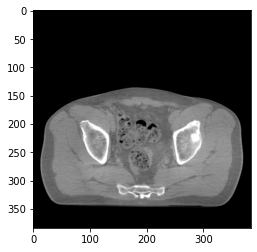

In [22]:
plt.imshow(x.squeeze(), 'gray'),

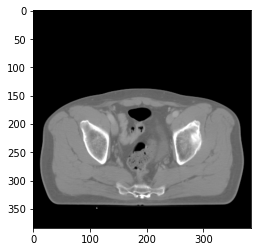

In [23]:
plt.imshow(y.squeeze(), 'gray')

In [24]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [25]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet152"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [26]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [27]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)

In [28]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [29]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME)
dis_optimizer = Optimizer(discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [30]:
wandb.watch(model)
wandb.watch(discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_air, loss_gen, loss_dis = train_a2b_epoch(model, gen_optimizer, discriminator, dis_optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_air_train, score_bone_train, score_acc_train = eval_epoch(model, discriminator, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_air_test, score_bone_test, score_acc_test = eval_epoch(model, discriminator, testloader, device)

        
        wandb.log({
            "loss ssim": loss_ssim,
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss gen": loss_gen,
            "loss dis": loss_dis,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_acc_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_acc_test
        })
        
        
        if score_bone_test +  score_air_test >  max_score:
            max_score = score_bone_test +  score_air_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "dicriminator": discriminator.state_dict(),
                "dis_optim": dis_optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

168it [02:06,  1.32it/s]
168it [00:37,  4.48it/s]
24it [00:05,  4.24it/s]
168it [02:07,  1.32it/s]
168it [00:41,  4.06it/s]
24it [00:05,  4.23it/s]
168it [02:07,  1.31it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.23it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.23it/s]
168it [02:12,  1.26it/s]
168it [00:41,  4.06it/s]
24it [00:05,  4.23it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.23it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:07,  1.31it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.22it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.20it/s]
168it [02:07,  1.31it/s]
168it [00:37,  4.46it/s]
24it [00:05,  4.22it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.44it/s]
24it [00:05,  4.20it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.43it/s]
24it [00:05,  4.22it/s]
168it [02:08,  1.31it/s]
168it [00:37,  4.45it/s]
24it [00:05,  4.22it/s]
168it [02:08,  1.31it/s]
168it [00:37,

In [31]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [32]:
model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=GEN_IN_CHANNELS, classes=GEN_N_CLASSES)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [33]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.9019690752029419
psnr score = 26.54761505126953
snr score = 16.610553741455078
mae error = 0.014389627613127232
air dice score = 0.9956876181474522
bone dice score = 0.9626769626774964


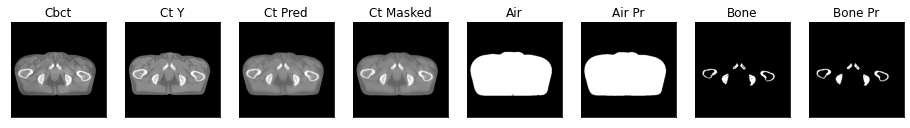

ssim score = 0.9024526476860046
psnr score = 26.553974151611328
snr score = 16.66444969177246
mae error = 0.0145127447322011
air dice score = 0.9958409942285232
bone dice score = 0.960079556755788


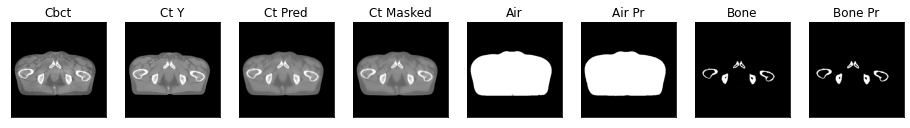

ssim score = 0.9003747701644897
psnr score = 26.354801177978516
snr score = 16.628171920776367
mae error = 0.015460938215255737
air dice score = 0.9954081080815377
bone dice score = 0.9523922875511497


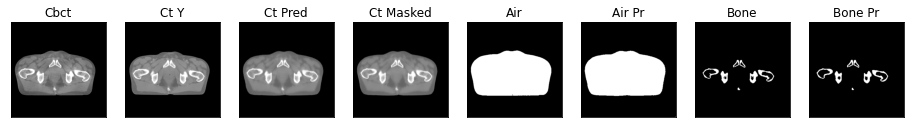

ssim score = 0.8981119394302368
psnr score = 26.42876625061035
snr score = 16.79138946533203
mae error = 0.01566026546061039
air dice score = 0.9955948004848719
bone dice score = 0.9454701588670517


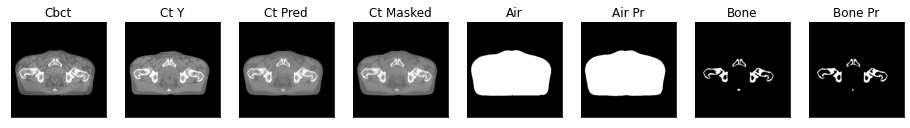

ssim score = 0.8982627987861633
psnr score = 26.57040786743164
snr score = 16.97333335876465
mae error = 0.015534603036940098
air dice score = 0.9951543679911442
bone dice score = 0.9344567453714661


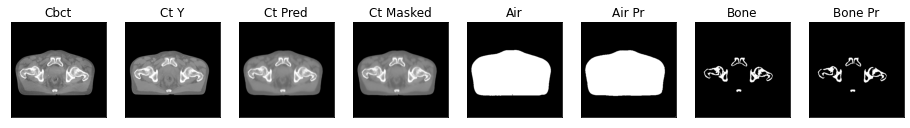

ssim score = 0.8939247727394104
psnr score = 26.504005432128906
snr score = 17.04346466064453
mae error = 0.016099372878670692
air dice score = 0.9959147159683953
bone dice score = 0.9250355976218692


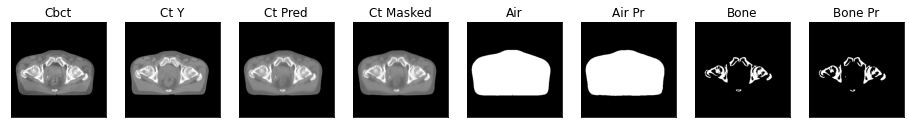

ssim score = 0.8928484320640564
psnr score = 26.636642456054688
snr score = 17.15204429626465
mae error = 0.016205506399273872
air dice score = 0.9959784718192953
bone dice score = 0.9284795885573089


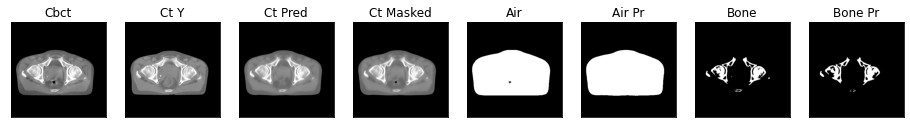

ssim score = 0.8944295644760132
psnr score = 26.961469650268555
snr score = 17.29133415222168
mae error = 0.015388906002044678
air dice score = 0.9965080355435726
bone dice score = 0.944000000000487


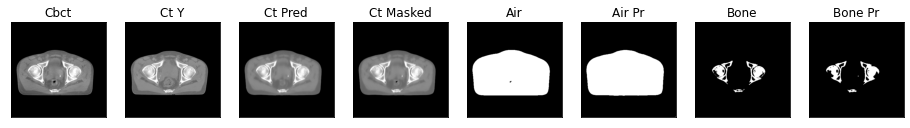

1it [00:02,  2.81s/it]

ssim score = 0.8975802659988403
psnr score = 27.121192932128906
snr score = 17.356502532958984
mae error = 0.014912722632288933
air dice score = 0.9961709110800501
bone dice score = 0.9499762695780734


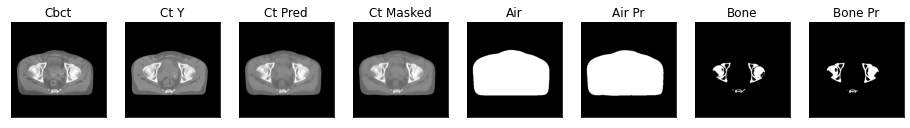

ssim score = 0.9022718667984009
psnr score = 27.538053512573242
snr score = 17.758079528808594
mae error = 0.014230553060770035
air dice score = 0.9958401305057138
bone dice score = 0.9453648915192765


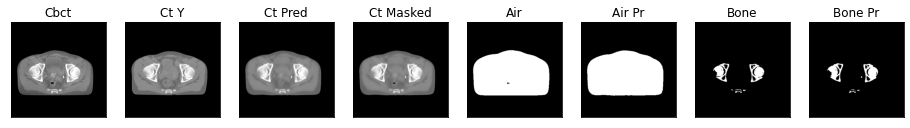

ssim score = 0.9068312048912048
psnr score = 27.778472900390625
snr score = 18.03076934814453
mae error = 0.0140125947073102
air dice score = 0.9961842240229807
bone dice score = 0.9576431117639165


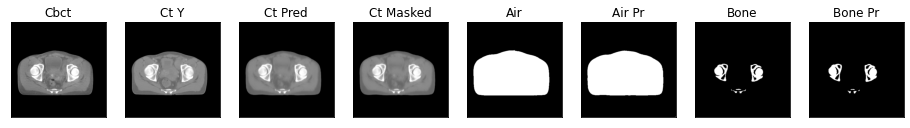

ssim score = 0.9069709181785583
psnr score = 27.70193862915039
snr score = 17.97794532775879
mae error = 0.013915244489908218
air dice score = 0.9936404529238472
bone dice score = 0.9639137296163712


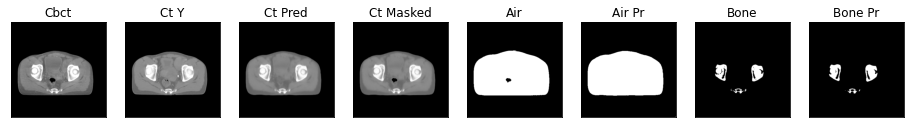

ssim score = 0.9137153625488281
psnr score = 27.854520797729492
snr score = 18.09860610961914
mae error = 0.013851343654096127
air dice score = 0.9910218041898341
bone dice score = 0.9709798566066805


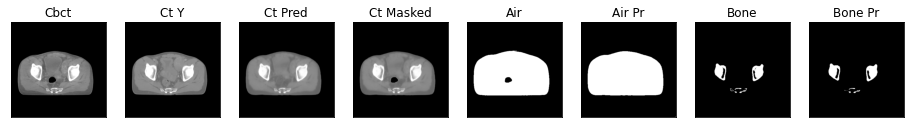

ssim score = 0.9102534055709839
psnr score = 27.687114715576172
snr score = 17.789243698120117
mae error = 0.01427563838660717
air dice score = 0.9900016803898609
bone dice score = 0.9475922451538763


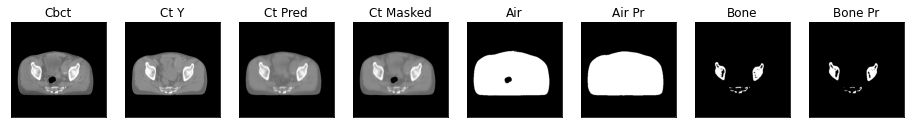

ssim score = 0.9104048013687134
psnr score = 27.612346649169922
snr score = 17.628814697265625
mae error = 0.014252315275371075
air dice score = 0.9914327417341914
bone dice score = 0.9292200854710307


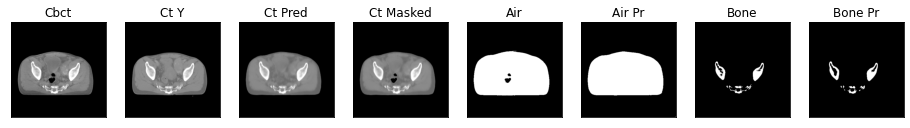

ssim score = 0.9030434489250183
psnr score = 26.81415557861328
snr score = 16.85410499572754
mae error = 0.01538925338536501
air dice score = 0.9917971662938193
bone dice score = 0.9360457724102219


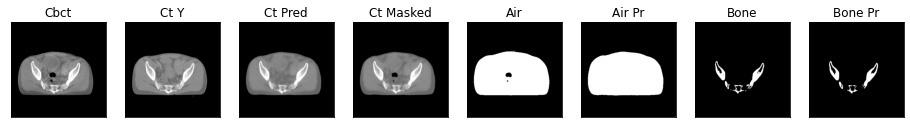

2it [00:05,  2.71s/it]

ssim score = 0.8989960551261902
psnr score = 26.146747589111328
snr score = 16.184154510498047
mae error = 0.016276858747005463
air dice score = 0.9894154852311712
bone dice score = 0.9425397204641913


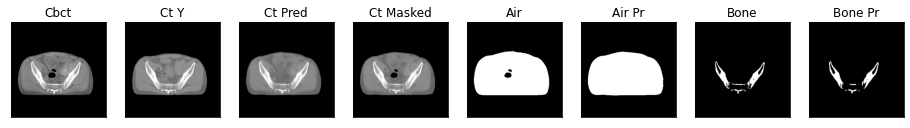

ssim score = 0.8948409557342529
psnr score = 25.764453887939453
snr score = 15.700101852416992
mae error = 0.016764452680945396
air dice score = 0.9869971865257536
bone dice score = 0.9207630227449161


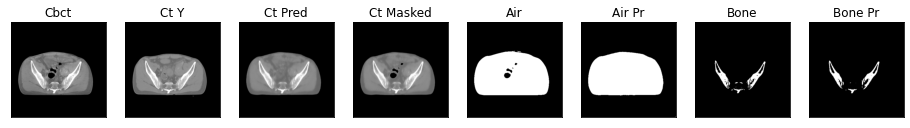

ssim score = 0.891521692276001
psnr score = 25.223041534423828
snr score = 15.108003616333008
mae error = 0.01750371791422367
air dice score = 0.9872585645891219
bone dice score = 0.9288663442263906


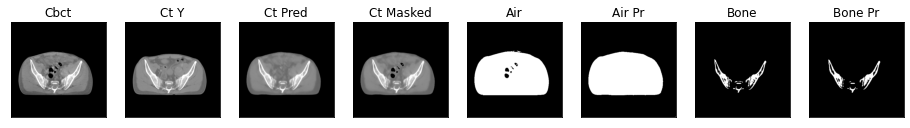

ssim score = 0.890984296798706
psnr score = 24.7065372467041
snr score = 14.579193115234375
mae error = 0.01839059591293335
air dice score = 0.9889075481704206
bone dice score = 0.9317008762461684


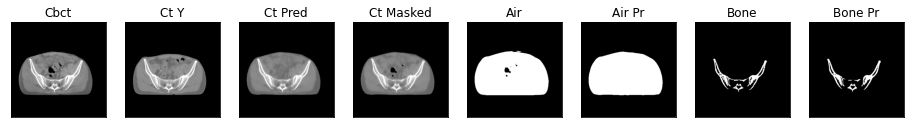

ssim score = 0.8866935968399048
psnr score = 24.246627807617188
snr score = 14.054436683654785
mae error = 0.019204076379537582
air dice score = 0.9900132784342718
bone dice score = 0.9151018249151666


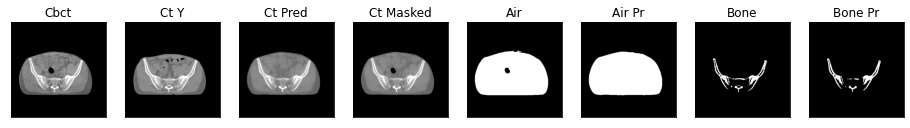

ssim score = 0.8766043186187744
psnr score = 22.410823822021484
snr score = 12.15920352935791
mae error = 0.02231638692319393
air dice score = 0.986412492395067
bone dice score = 0.864786695590928


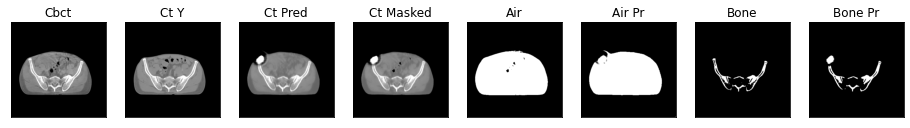

ssim score = 0.8883797526359558
psnr score = 23.941133499145508
snr score = 13.656083106994629
mae error = 0.019124682992696762
air dice score = 0.9929882074397931
bone dice score = 0.9372255844317404


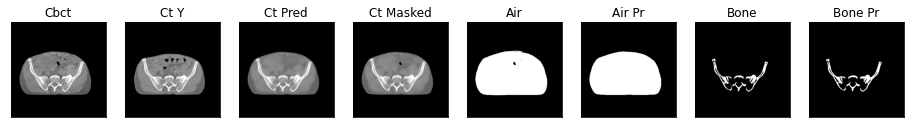

ssim score = 0.8876345157623291
psnr score = 23.733505249023438
snr score = 13.39989185333252
mae error = 0.019557705149054527
air dice score = 0.9925436678710416
bone dice score = 0.9321412196248035


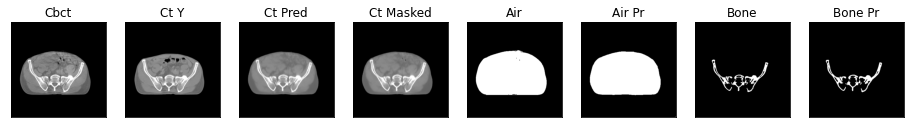

3it [00:07,  2.64s/it]

ssim score = 0.8875123262405396
psnr score = 23.630565643310547
snr score = 13.19995403289795
mae error = 0.019757261499762535
air dice score = 0.9919945852588433
bone dice score = 0.9339412811395247


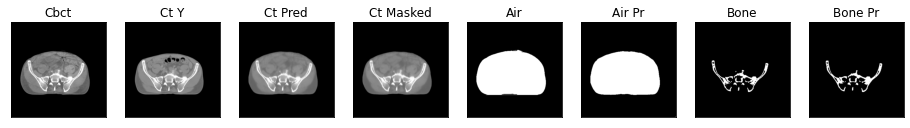

ssim score = 0.8886553645133972
psnr score = 23.839324951171875
snr score = 13.325976371765137
mae error = 0.01922379806637764
air dice score = 0.9928165540902841
bone dice score = 0.9186033456840843


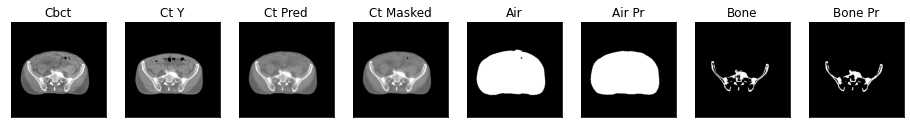

ssim score = 0.8877941966056824
psnr score = 23.850189208984375
snr score = 13.245654106140137
mae error = 0.01944689452648163
air dice score = 0.9907867105279242
bone dice score = 0.9220607661831566


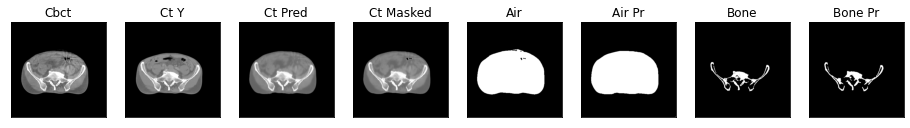

ssim score = 0.8880400657653809
psnr score = 23.717985153198242
snr score = 13.072345733642578
mae error = 0.019842276349663734
air dice score = 0.9897703241036864
bone dice score = 0.9330019674854199


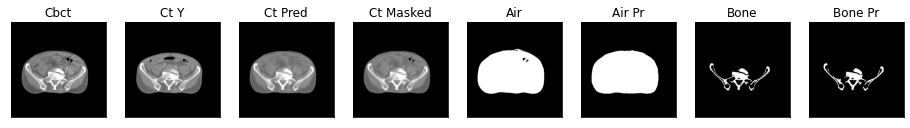

ssim score = 0.8730822801589966
psnr score = 23.904064178466797
snr score = 15.276220321655273
mae error = 0.020468147471547127
air dice score = 0.9921094550708222
bone dice score = 0.9775140537171295


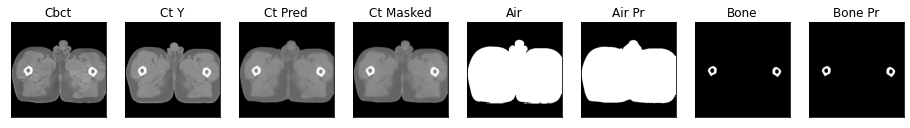

ssim score = 0.8757508397102356
psnr score = 24.255678176879883
snr score = 15.667093276977539
mae error = 0.01963832415640354
air dice score = 0.9912784826395955
bone dice score = 0.9763503649641941


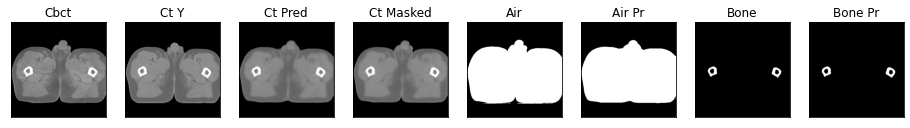

ssim score = 0.8872748017311096
psnr score = 25.198871612548828
snr score = 16.697736740112305
mae error = 0.0180907491594553
air dice score = 0.9922780392299975
bone dice score = 0.9701353243124093


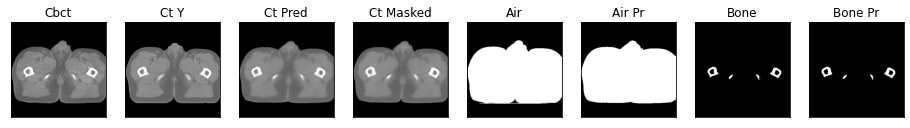

ssim score = 0.893007755279541
psnr score = 25.769033432006836
snr score = 17.43045425415039
mae error = 0.017867371439933777
air dice score = 0.9936141493502209
bone dice score = 0.9717748365496448


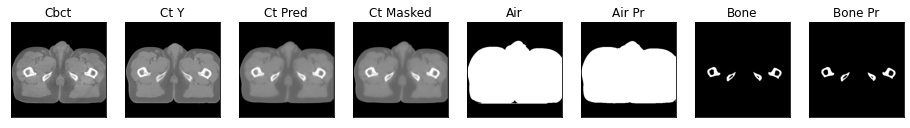

4it [00:10,  2.53s/it]

ssim score = 0.8977910280227661
psnr score = 26.32516098022461
snr score = 18.11472511291504
mae error = 0.017260128632187843
air dice score = 0.9942969447056872
bone dice score = 0.9594034797023004


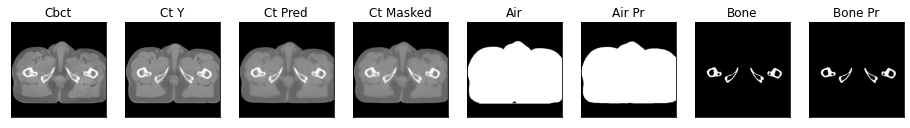

ssim score = 0.9008401036262512
psnr score = 26.925777435302734
snr score = 18.818580627441406
mae error = 0.016648169606924057
air dice score = 0.9945329584504875
bone dice score = 0.9561278016218868


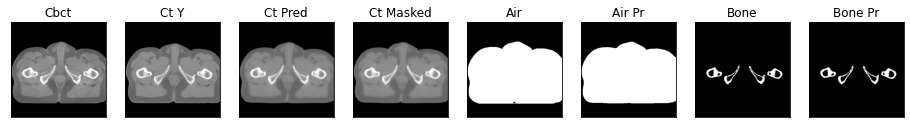

ssim score = 0.9042174220085144
psnr score = 27.421911239624023
snr score = 19.381813049316406
mae error = 0.016357706859707832
air dice score = 0.9951119699897721
bone dice score = 0.9518798640803258


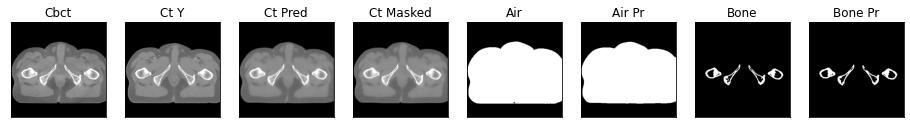

ssim score = 0.903359055519104
psnr score = 27.5858154296875
snr score = 19.53582763671875
mae error = 0.016086529940366745
air dice score = 0.995335909915071
bone dice score = 0.9578512396698569


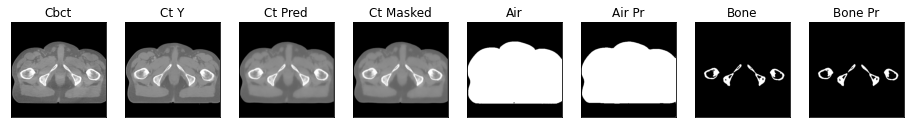

ssim score = 0.9051702618598938
psnr score = 27.65019416809082
snr score = 19.586544036865234
mae error = 0.0160552766174078
air dice score = 0.9960130913418649
bone dice score = 0.9635934775924152


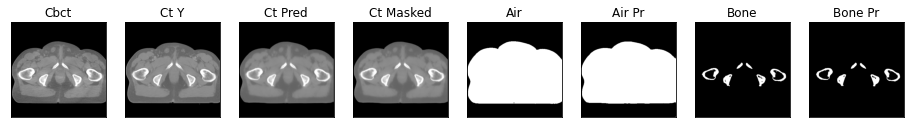

ssim score = 0.9082116484642029
psnr score = 27.954015731811523
snr score = 19.90236473083496
mae error = 0.015771882608532906
air dice score = 0.9958506224066415
bone dice score = 0.9537358818423791


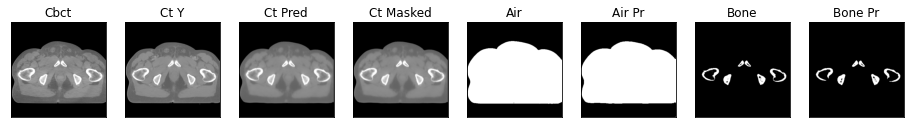

ssim score = 0.9089386463165283
psnr score = 27.991464614868164
snr score = 19.978897094726562
mae error = 0.015658780932426453
air dice score = 0.9958945535995462
bone dice score = 0.9571060589096527


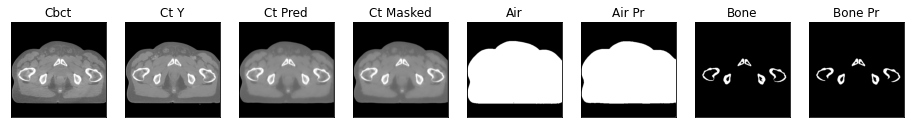

ssim score = 0.9057325720787048
psnr score = 27.73992347717285
snr score = 19.86864471435547
mae error = 0.01654430665075779
air dice score = 0.9962584630003586
bone dice score = 0.9567376563847126


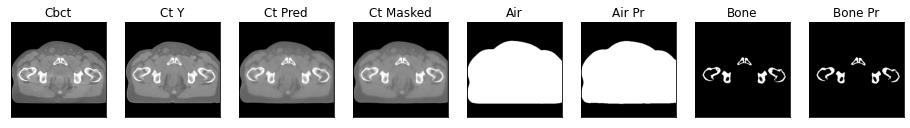

5it [00:12,  2.52s/it]

ssim score = 0.9074224233627319
psnr score = 27.979522705078125
snr score = 20.202932357788086
mae error = 0.01652071438729763
air dice score = 0.9966695213626435
bone dice score = 0.9544620783160184


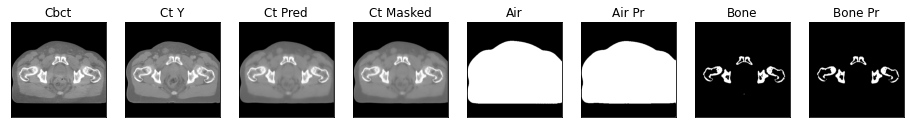

ssim score = 0.8976530432701111
psnr score = 27.278236389160156
snr score = 19.467599868774414
mae error = 0.018131205812096596
air dice score = 0.996892983868565
bone dice score = 0.9292419342121224


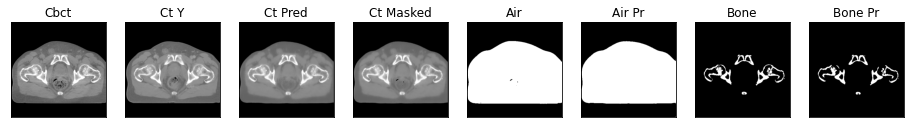

ssim score = 0.8972654342651367
psnr score = 27.36200714111328
snr score = 19.623558044433594
mae error = 0.01809365302324295
air dice score = 0.9954104804016756
bone dice score = 0.8982933259338262


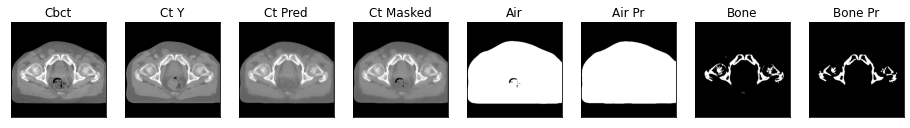

ssim score = 0.8917850255966187
psnr score = 27.05080223083496
snr score = 19.176258087158203
mae error = 0.018304971978068352
air dice score = 0.9956183320811446
bone dice score = 0.8855676600352429


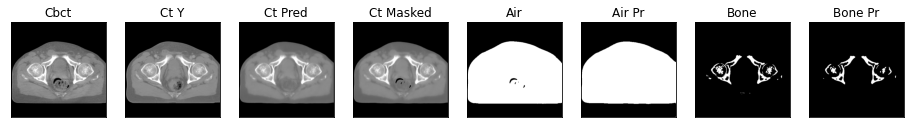

ssim score = 0.8954247832298279
psnr score = 26.83885955810547
snr score = 18.785755157470703
mae error = 0.017663221806287766
air dice score = 0.9950165311195338
bone dice score = 0.8747957516352656


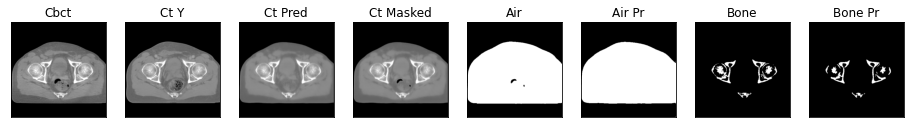

ssim score = 0.8918142914772034
psnr score = 26.27082061767578
snr score = 18.127124786376953
mae error = 0.01860078237950802
air dice score = 0.9965228854608256
bone dice score = 0.8675756875448627


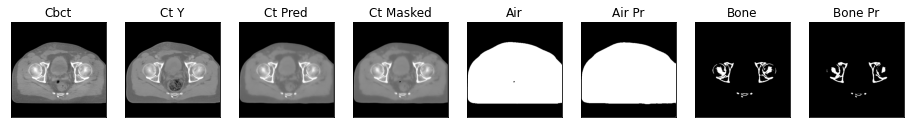

ssim score = 0.891742467880249
psnr score = 26.016542434692383
snr score = 17.888540267944336
mae error = 0.01884053274989128
air dice score = 0.9967477796757526
bone dice score = 0.8836662749718656


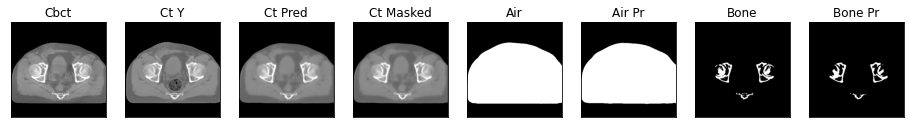

ssim score = 0.8826301097869873
psnr score = 25.922143936157227
snr score = 17.804174423217773
mae error = 0.019590720534324646
air dice score = 0.9965281173594154
bone dice score = 0.9001226068103355


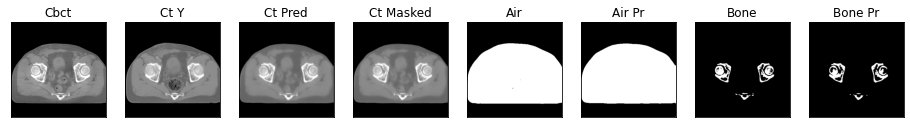

6it [00:15,  2.52s/it]

ssim score = 0.889301598072052
psnr score = 26.241374969482422
snr score = 18.184993743896484
mae error = 0.018964825198054314
air dice score = 0.9961963656887669
bone dice score = 0.930253872239664


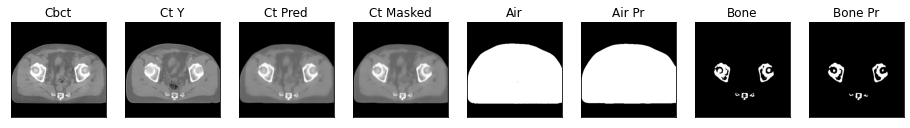

ssim score = 0.8934555053710938
psnr score = 27.186988830566406
snr score = 19.20069122314453
mae error = 0.017868483439087868
air dice score = 0.9956888334020112
bone dice score = 0.9636205395999685


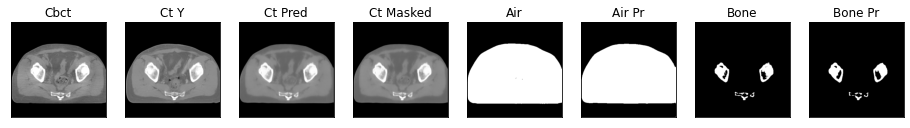

ssim score = 0.8964329957962036
psnr score = 26.772323608398438
snr score = 18.666919708251953
mae error = 0.018121536821126938
air dice score = 0.9956333489138751
bone dice score = 0.9316324496717996


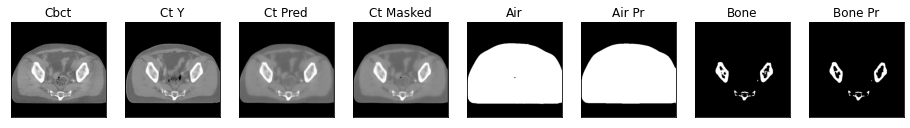

ssim score = 0.8906258940696716
psnr score = 26.144229888916016
snr score = 18.120452880859375
mae error = 0.019847460091114044
air dice score = 0.9941560716019529
bone dice score = 0.9552845528459072


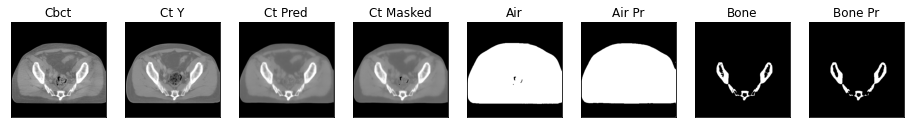

ssim score = 0.8912228345870972
psnr score = 26.38881492614746
snr score = 18.4451847076416
mae error = 0.01957756094634533
air dice score = 0.9933302710151626
bone dice score = 0.9487690337274173


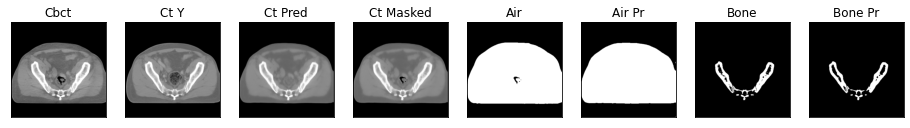

ssim score = 0.8764172196388245
psnr score = 25.92582893371582
snr score = 18.00375747680664
mae error = 0.021306313574314117
air dice score = 0.9921802453448071
bone dice score = 0.9431423918434955


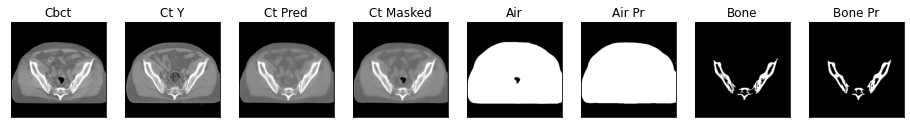

ssim score = 0.8801280856132507
psnr score = 26.14319610595703
snr score = 18.23366355895996
mae error = 0.021256424486637115
air dice score = 0.9945188017845795
bone dice score = 0.9511377416366992


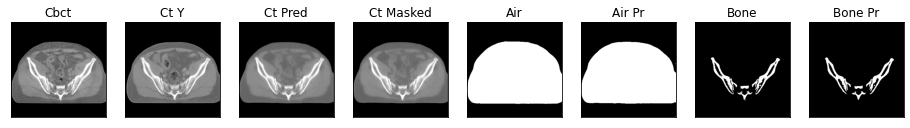

ssim score = 0.8191193342208862
psnr score = 21.12283706665039
snr score = 11.003045082092285
mae error = 0.03151008114218712
air dice score = 0.9943028325353783
bone dice score = 0.9658563234098373


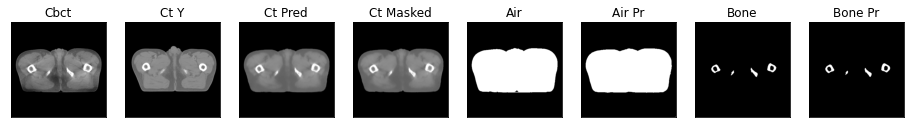

7it [00:17,  2.45s/it]

ssim score = 0.8072237968444824
psnr score = 20.741024017333984
snr score = 10.834212303161621
mae error = 0.03389628604054451
air dice score = 0.9942852079918537
bone dice score = 0.9377797672350542


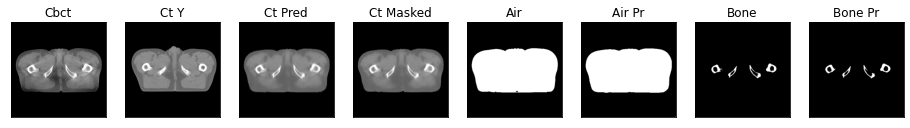

ssim score = 0.8030513525009155
psnr score = 20.735824584960938
snr score = 10.960151672363281
mae error = 0.03443524241447449
air dice score = 0.9945869699374111
bone dice score = 0.9016107966934782


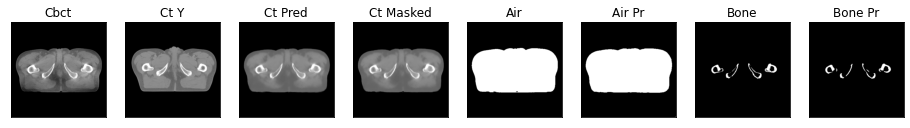

ssim score = 0.8062025308609009
psnr score = 21.072368621826172
snr score = 11.367100715637207
mae error = 0.03344865143299103
air dice score = 0.9940455832960686
bone dice score = 0.8982188295186977


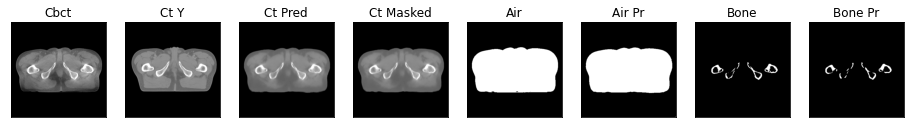

ssim score = 0.8069027066230774
psnr score = 21.12957763671875
snr score = 11.471874237060547
mae error = 0.03348628059029579
air dice score = 0.9934582218257565
bone dice score = 0.8880658436237023


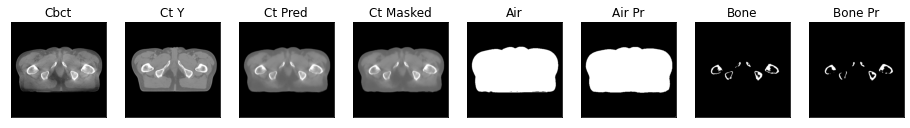

ssim score = 0.8095399141311646
psnr score = 21.292936325073242
snr score = 11.640849113464355
mae error = 0.03285821154713631
air dice score = 0.9931691486299099
bone dice score = 0.9023055881222684


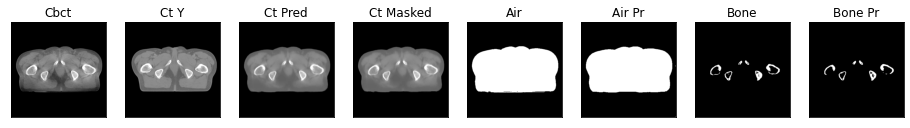

ssim score = 0.8137423396110535
psnr score = 21.395875930786133
snr score = 11.737284660339355
mae error = 0.03210112452507019
air dice score = 0.9923394327698241
bone dice score = 0.9310477657948566


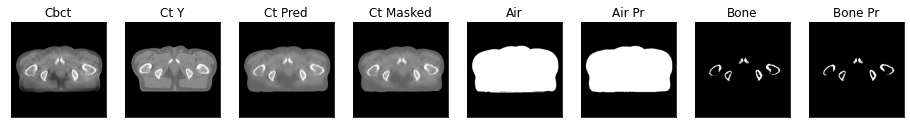

ssim score = 0.814115583896637
psnr score = 21.263952255249023
snr score = 11.61947250366211
mae error = 0.03241712599992752
air dice score = 0.9927230148748925
bone dice score = 0.9427247451354454


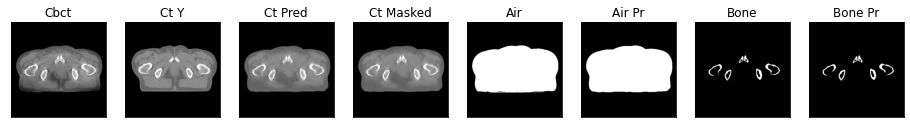

ssim score = 0.8141211271286011
psnr score = 21.223831176757812
snr score = 11.637359619140625
mae error = 0.033103097230196
air dice score = 0.992427130627671
bone dice score = 0.9091219096349681


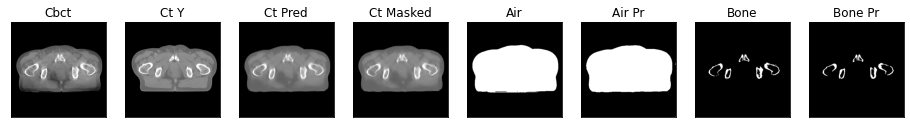

8it [00:19,  2.46s/it]

ssim score = 0.805674135684967
psnr score = 21.031967163085938
snr score = 11.544052124023438
mae error = 0.03497762233018875
air dice score = 0.9916449943407221
bone dice score = 0.8703548007420489


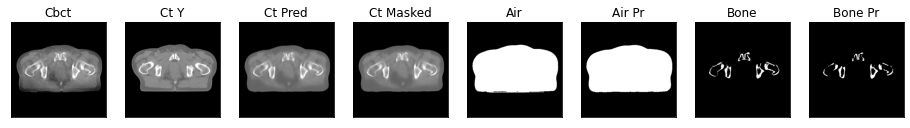

ssim score = 0.792026937007904
psnr score = 20.80716323852539
snr score = 11.355080604553223
mae error = 0.03686496242880821
air dice score = 0.9930643507629274
bone dice score = 0.8666026871422489


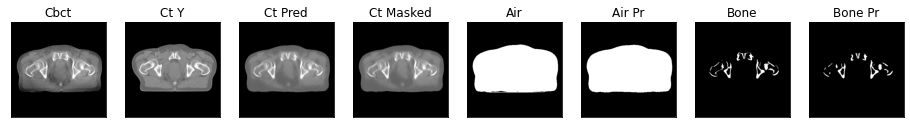

ssim score = 0.7802463173866272
psnr score = 20.711978912353516
snr score = 11.29259967803955
mae error = 0.03703694045543671
air dice score = 0.9944392796887421
bone dice score = 0.8411053540610088


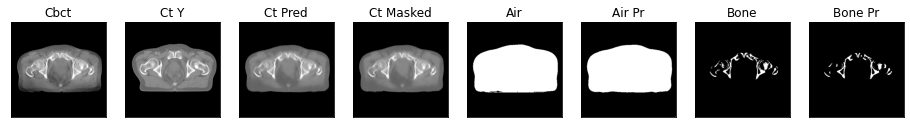

ssim score = 0.7815690040588379
psnr score = 20.69939422607422
snr score = 11.396832466125488
mae error = 0.037653323262929916
air dice score = 0.9950015915758365
bone dice score = 0.8226804123737455


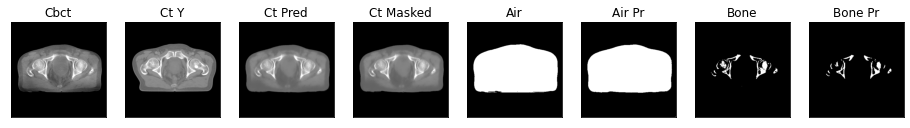

ssim score = 0.7843002676963806
psnr score = 20.611026763916016
snr score = 11.292476654052734
mae error = 0.03792604058980942
air dice score = 0.994787814150315
bone dice score = 0.8209176122377747


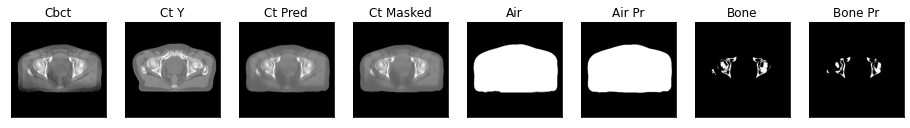

ssim score = 0.800042986869812
psnr score = 21.15248680114746
snr score = 11.634775161743164
mae error = 0.03459357097744942
air dice score = 0.9947311874167393
bone dice score = 0.8459130434809407


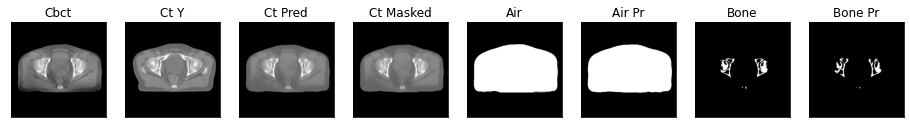

ssim score = 0.8161668181419373
psnr score = 21.91354751586914
snr score = 12.225444793701172
mae error = 0.031057365238666534
air dice score = 0.9946734142471204
bone dice score = 0.8945264452660743


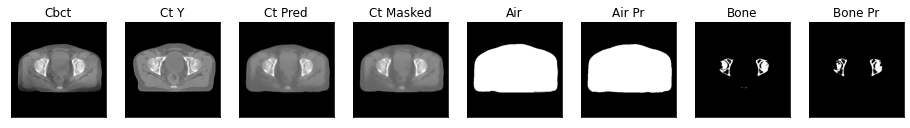

ssim score = 0.823482871055603
psnr score = 22.274288177490234
snr score = 12.600353240966797
mae error = 0.02931351214647293
air dice score = 0.9948081051722265
bone dice score = 0.9317401455853352


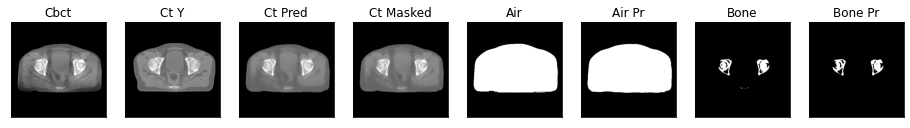

9it [00:22,  2.46s/it]

ssim score = 0.8282273411750793
psnr score = 22.486038208007812
snr score = 12.893929481506348
mae error = 0.028962546959519386
air dice score = 0.995342716264606
bone dice score = 0.9524460235043394


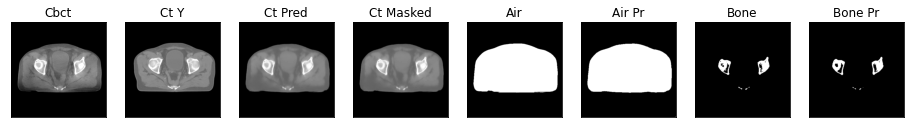

ssim score = 0.8280655741691589
psnr score = 22.46125030517578
snr score = 12.961315155029297
mae error = 0.029161831364035606
air dice score = 0.9948291577575455
bone dice score = 0.9367245657578052


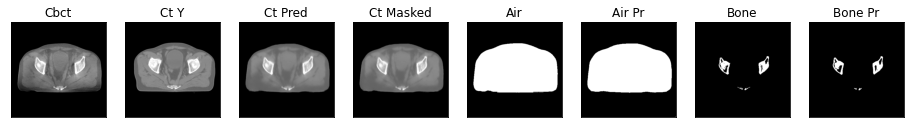

ssim score = 0.8267625570297241
psnr score = 22.75371742248535
snr score = 13.190356254577637
mae error = 0.028023114427924156
air dice score = 0.9951256793478302
bone dice score = 0.9386145404674449


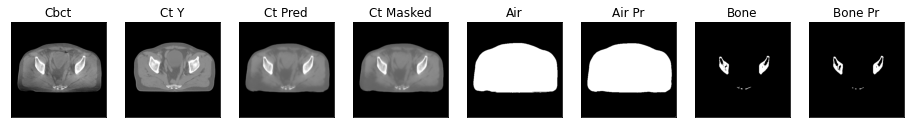

ssim score = 0.8334269523620605
psnr score = 23.198440551757812
snr score = 13.598684310913086
mae error = 0.026315204799175262
air dice score = 0.9941142546984242
bone dice score = 0.9531307213483499


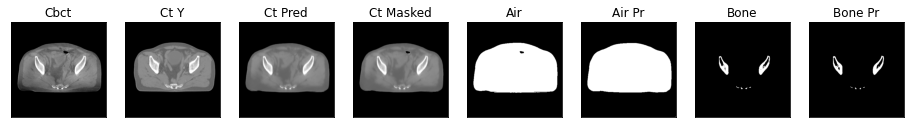

ssim score = 0.8300134539604187
psnr score = 23.002479553222656
snr score = 13.440470695495605
mae error = 0.027706371620297432
air dice score = 0.9942914337577343
bone dice score = 0.9186206896565755


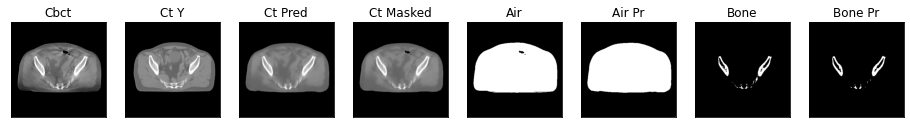

ssim score = 0.823570728302002
psnr score = 22.735885620117188
snr score = 13.304381370544434
mae error = 0.029015246778726578
air dice score = 0.9945043277357367
bone dice score = 0.9239852398535205


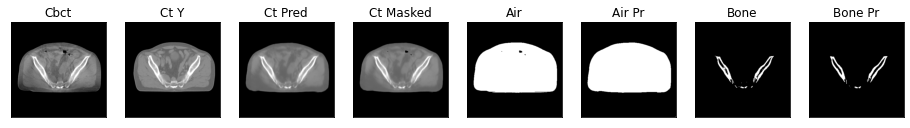

ssim score = 0.8291782736778259
psnr score = 22.861413955688477
snr score = 13.447656631469727
mae error = 0.028481245040893555
air dice score = 0.9942768438201051
bone dice score = 0.9094363521230299


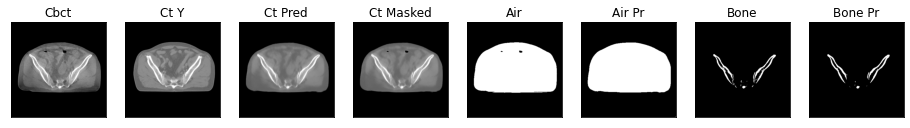

ssim score = 0.8316540122032166
psnr score = 23.131839752197266
snr score = 13.706816673278809
mae error = 0.027939800173044205
air dice score = 0.9946672610984459
bone dice score = 0.9210660329329304


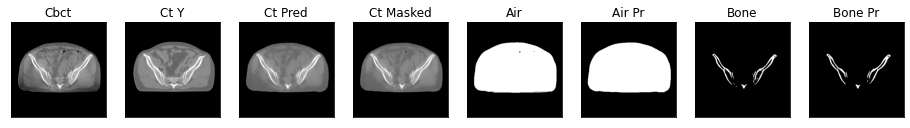

10it [00:24,  2.41s/it]

ssim score = 0.8356892466545105
psnr score = 23.31298065185547
snr score = 13.887216567993164
mae error = 0.027105391025543213
air dice score = 0.9945610481403314
bone dice score = 0.9016641452361461


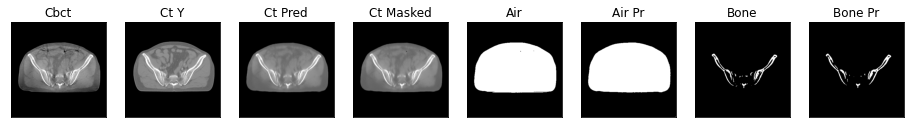

ssim score = 0.8841005563735962
psnr score = 24.781063079833984
snr score = 15.215195655822754
mae error = 0.018095165491104126
air dice score = 0.9926036798484171
bone dice score = 0.9622281571933526


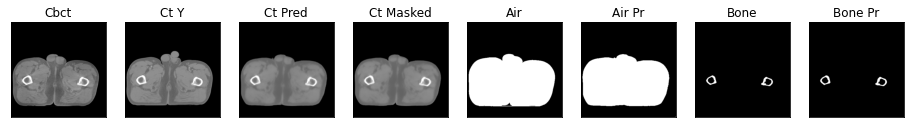

ssim score = 0.8832103610038757
psnr score = 25.054471969604492
snr score = 15.552998542785645
mae error = 0.01787058264017105
air dice score = 0.9921292231266426
bone dice score = 0.9429577464808818


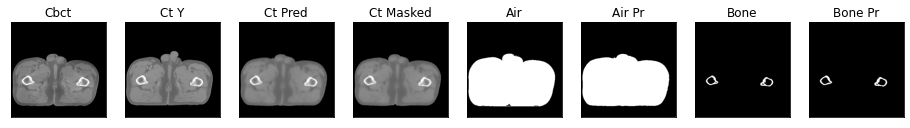

ssim score = 0.893966794013977
psnr score = 27.04696273803711
snr score = 17.684701919555664
mae error = 0.01623438484966755
air dice score = 0.9918677572212815
bone dice score = 0.949977053695503


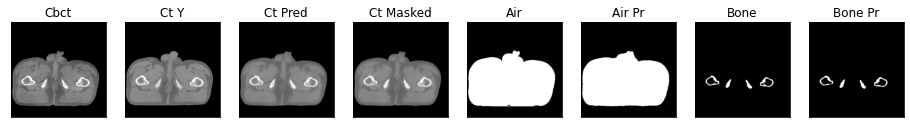

ssim score = 0.8936514258384705
psnr score = 26.909400939941406
snr score = 17.66863250732422
mae error = 0.016628911718726158
air dice score = 0.9932713624518741
bone dice score = 0.9383044829130425


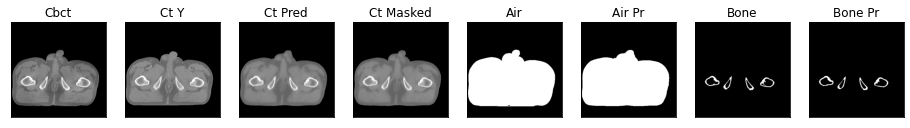

ssim score = 0.8871596455574036
psnr score = 26.436119079589844
snr score = 17.21952247619629
mae error = 0.017432859167456627
air dice score = 0.9943038957007649
bone dice score = 0.9124854142377483


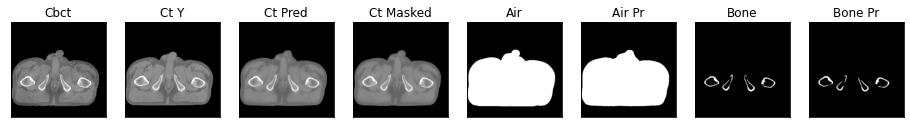

ssim score = 0.8897978067398071
psnr score = 26.439956665039062
snr score = 17.218965530395508
mae error = 0.01725837029516697
air dice score = 0.9941234843551384
bone dice score = 0.9071856287444999


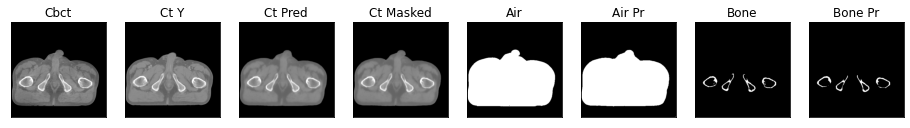

ssim score = 0.8908873200416565
psnr score = 25.9737606048584
snr score = 16.759021759033203
mae error = 0.0177762471139431
air dice score = 0.9948292569479478
bone dice score = 0.8937147630007577


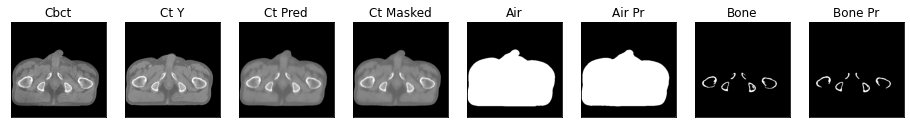

11it [00:27,  2.43s/it]

ssim score = 0.8883574604988098
psnr score = 25.607404708862305
snr score = 16.371110916137695
mae error = 0.017839938402175903
air dice score = 0.9952294147306402
bone dice score = 0.9186893203899942


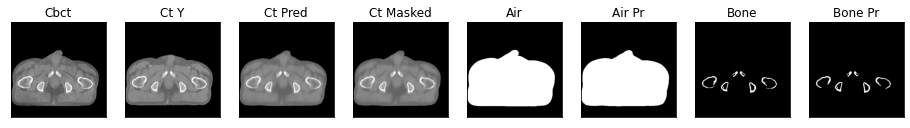

ssim score = 0.8898101449012756
psnr score = 25.693939208984375
snr score = 16.47455406188965
mae error = 0.017491083592176437
air dice score = 0.9952467267762576
bone dice score = 0.929741947637413


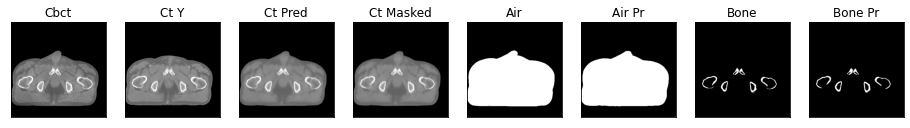

ssim score = 0.8896997570991516
psnr score = 25.916784286499023
snr score = 16.765993118286133
mae error = 0.01757144369184971
air dice score = 0.9957437503416747
bone dice score = 0.9198895027638141


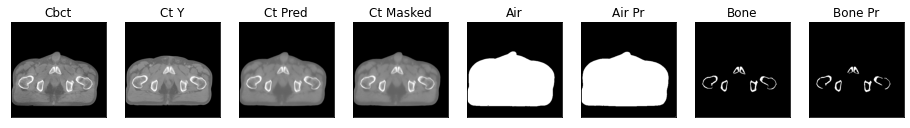

ssim score = 0.8892008066177368
psnr score = 26.254859924316406
snr score = 17.1854248046875
mae error = 0.0175092164427042
air dice score = 0.9957196613358453
bone dice score = 0.9084745762726638


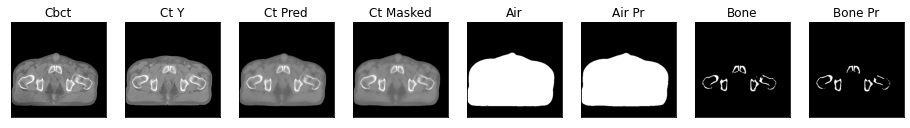

ssim score = 0.890379786491394
psnr score = 26.791736602783203
snr score = 17.773006439208984
mae error = 0.017311612144112587
air dice score = 0.9961602014320591
bone dice score = 0.8596181614012576


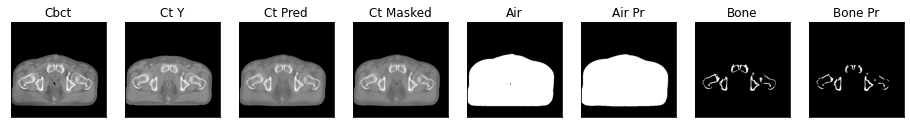

ssim score = 0.8938002586364746
psnr score = 27.154577255249023
snr score = 18.252117156982422
mae error = 0.01697392575442791
air dice score = 0.9962348743774154
bone dice score = 0.842980112795444


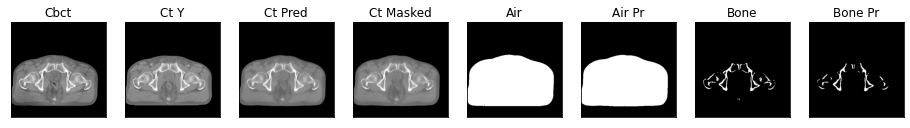

ssim score = 0.8942052721977234
psnr score = 27.480724334716797
snr score = 18.540027618408203
mae error = 0.016603022813796997
air dice score = 0.9946670681553487
bone dice score = 0.8255927249135175


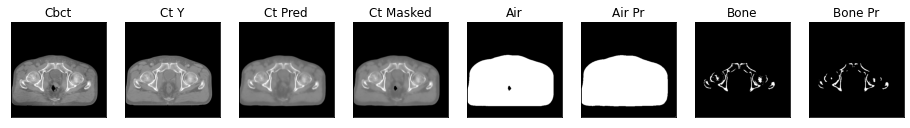

ssim score = 0.8945543169975281
psnr score = 27.8560848236084
snr score = 18.819721221923828
mae error = 0.015758754685521126
air dice score = 0.990896749980044
bone dice score = 0.8123207005916908


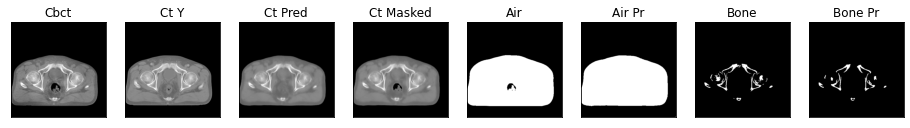

12it [00:29,  2.45s/it]

ssim score = 0.8990191221237183
psnr score = 28.01955795288086
snr score = 18.82343101501465
mae error = 0.015550313517451286
air dice score = 0.9891046897205203
bone dice score = 0.825555555558786


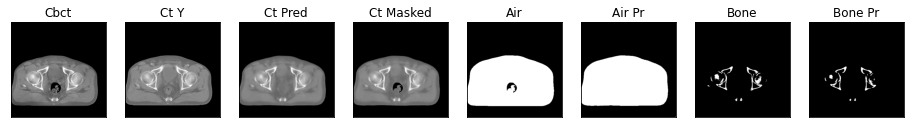

ssim score = 0.8945031762123108
psnr score = 27.140201568603516
snr score = 17.827651977539062
mae error = 0.016095135360956192
air dice score = 0.9872693995886144
bone dice score = 0.8247225411438055


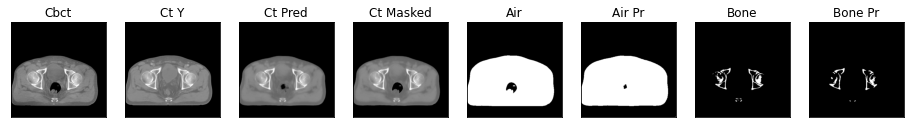

ssim score = 0.889437198638916
psnr score = 25.896286010742188
snr score = 16.53864097595215
mae error = 0.017346104606986046
air dice score = 0.9893240180960026
bone dice score = 0.8451555555583083


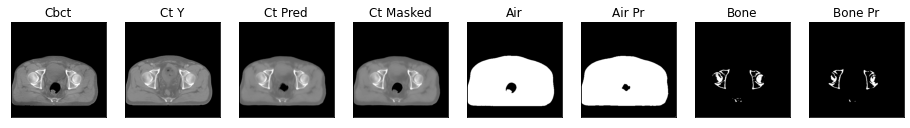

ssim score = 0.8852718472480774
psnr score = 25.755970001220703
snr score = 16.404998779296875
mae error = 0.018051115795969963
air dice score = 0.9873512938964168
bone dice score = 0.9004899476279694


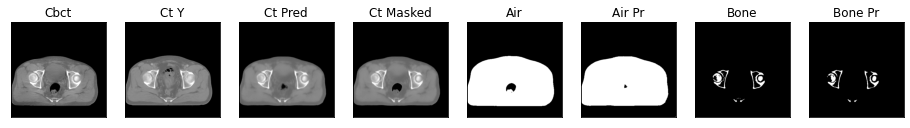

ssim score = 0.8851214647293091
psnr score = 24.601171493530273
snr score = 15.280303955078125
mae error = 0.019728541374206543
air dice score = 0.9904888735439505
bone dice score = 0.9348986125943757


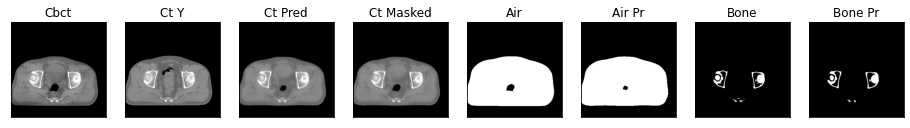

ssim score = 0.8884057998657227
psnr score = 25.13431739807129
snr score = 15.770864486694336
mae error = 0.01854991354048252
air dice score = 0.9925373134328419
bone dice score = 0.9226500173443869


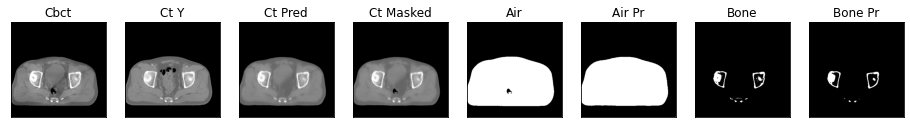

ssim score = 0.8908787369728088
psnr score = 24.996585845947266
snr score = 15.542925834655762
mae error = 0.01829211413860321
air dice score = 0.9938016528925671
bone dice score = 0.9040174153986935


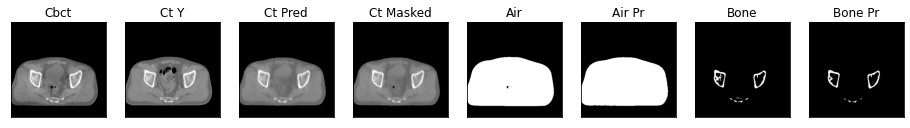

ssim score = 0.8909800052642822
psnr score = 25.127368927001953
snr score = 15.60798454284668
mae error = 0.017974229529500008
air dice score = 0.9928406524257662
bone dice score = 0.931187122737803


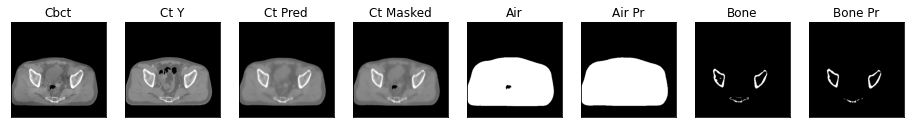

13it [00:31,  2.40s/it]

ssim score = 0.891677737236023
psnr score = 25.513954162597656
snr score = 15.994268417358398
mae error = 0.017609430477023125
air dice score = 0.9918719666817876
bone dice score = 0.926117144384438


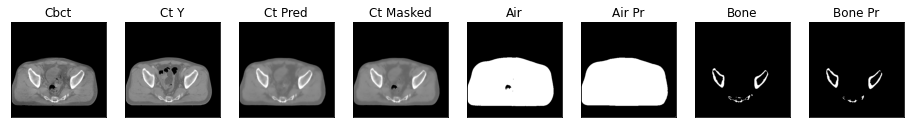

ssim score = 0.8876495957374573
psnr score = 25.642873764038086
snr score = 16.199356079101562
mae error = 0.018172387033700943
air dice score = 0.9913501698619998
bone dice score = 0.9015590200460051


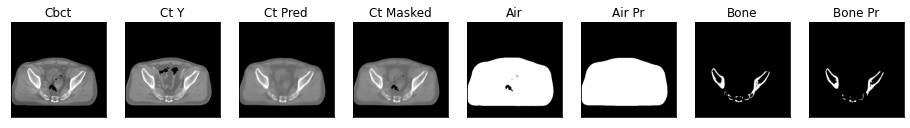

ssim score = 0.891495406627655
psnr score = 25.73307228088379
snr score = 16.325132369995117
mae error = 0.017884518951177597
air dice score = 0.9914481769766562
bone dice score = 0.9138566552912784


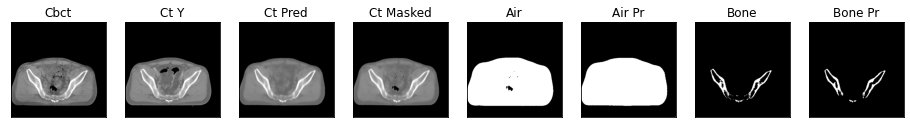

ssim score = 0.8926429748535156
psnr score = 25.865745544433594
snr score = 16.396108627319336
mae error = 0.017489710822701454
air dice score = 0.9918953529346112
bone dice score = 0.9076879108329853


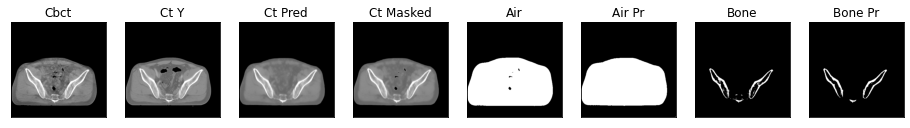

ssim score = 0.8890681266784668
psnr score = 25.457565307617188
snr score = 15.926668167114258
mae error = 0.01817169226706028
air dice score = 0.9924668637360607
bone dice score = 0.8984763916141427


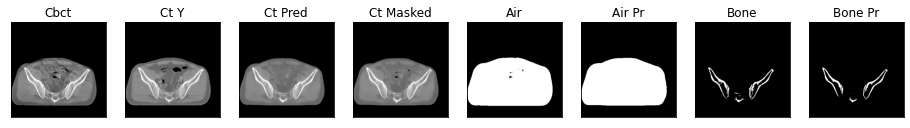

ssim score = 0.8289525508880615
psnr score = 22.896297454833984
snr score = 14.593603134155273
mae error = 0.027636850252747536
air dice score = 0.9928652073937064
bone dice score = 0.9721016739004308


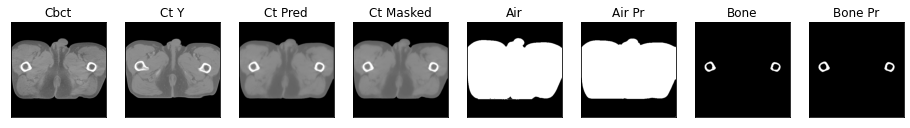

ssim score = 0.8197633028030396
psnr score = 22.512348175048828
snr score = 14.313946723937988
mae error = 0.029303623363375664
air dice score = 0.9942124455946393
bone dice score = 0.9668725435158093


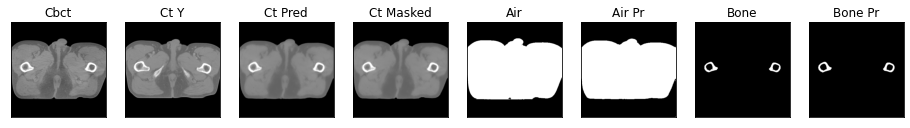

ssim score = 0.8108547925949097
psnr score = 22.071212768554688
snr score = 14.000767707824707
mae error = 0.032055485993623734
air dice score = 0.9954490006568479
bone dice score = 0.9453214367434152


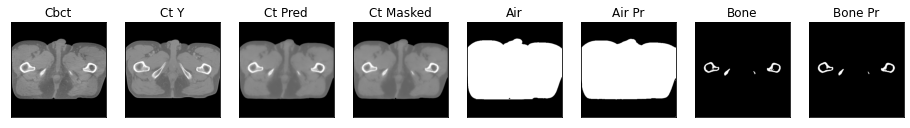

14it [00:34,  2.43s/it]

ssim score = 0.7989474534988403
psnr score = 21.588457107543945
snr score = 13.550300598144531
mae error = 0.03308876231312752
air dice score = 0.9959704538941581
bone dice score = 0.9531328741818724


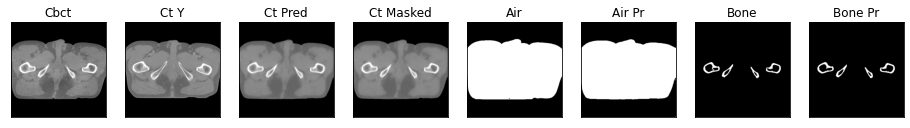

ssim score = 0.7911794185638428
psnr score = 21.507137298583984
snr score = 13.49921703338623
mae error = 0.033892758190631866
air dice score = 0.9957233291519614
bone dice score = 0.9303326162513597


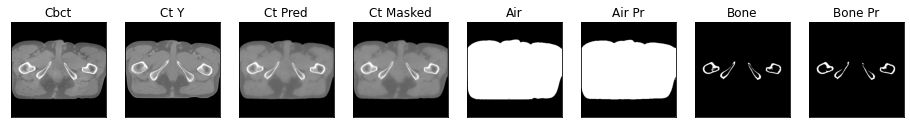

ssim score = 0.7837854623794556
psnr score = 21.406614303588867
snr score = 13.433113098144531
mae error = 0.03476410731673241
air dice score = 0.9955621215734428
bone dice score = 0.9303201506602272


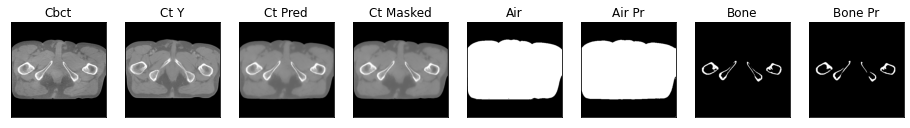

ssim score = 0.7767430543899536
psnr score = 21.13185691833496
snr score = 13.17866325378418
mae error = 0.03582983464002609
air dice score = 0.9956938769596362
bone dice score = 0.9292929292939076


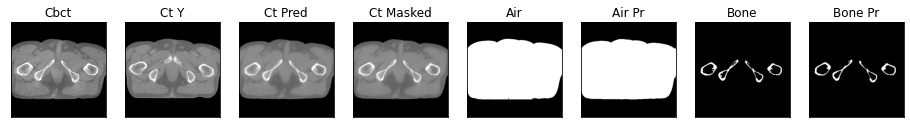

ssim score = 0.7762758731842041
psnr score = 21.171405792236328
snr score = 13.257285118103027
mae error = 0.035516202449798584
air dice score = 0.9950120359226027
bone dice score = 0.9218921892199959


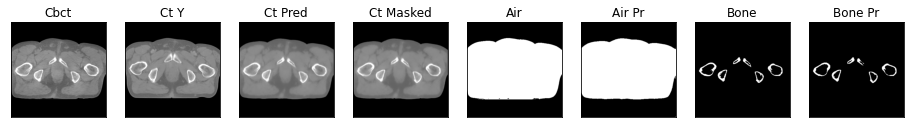

ssim score = 0.7758392691612244
psnr score = 21.298620223999023
snr score = 13.433183670043945
mae error = 0.035312049090862274
air dice score = 0.9946078544815009
bone dice score = 0.9294164562019219


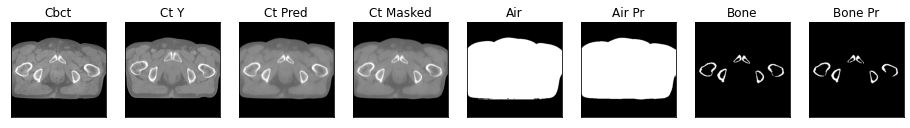

ssim score = 0.7676844596862793
psnr score = 21.095382690429688
snr score = 13.252554893493652
mae error = 0.03717457503080368
air dice score = 0.9942080924855525
bone dice score = 0.925070567103861


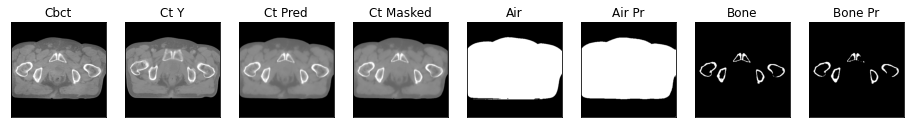

ssim score = 0.7572111487388611
psnr score = 21.05353355407715
snr score = 13.253484725952148
mae error = 0.03847349062561989
air dice score = 0.9947735794635162
bone dice score = 0.9075711689896114


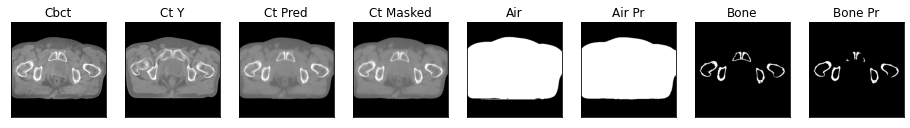

15it [00:36,  2.45s/it]

ssim score = 0.7592248916625977
psnr score = 21.12459945678711
snr score = 13.382888793945312
mae error = 0.03837115317583084
air dice score = 0.9952204846233068
bone dice score = 0.9074280615669481


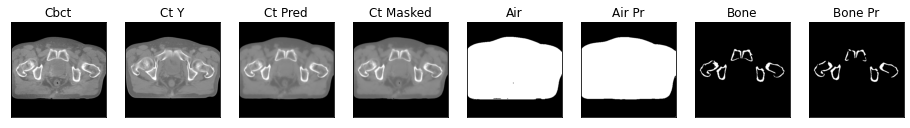

ssim score = 0.7518002390861511
psnr score = 20.83114242553711
snr score = 13.014059066772461
mae error = 0.04081714153289795
air dice score = 0.9961750956226116
bone dice score = 0.8881578947379918


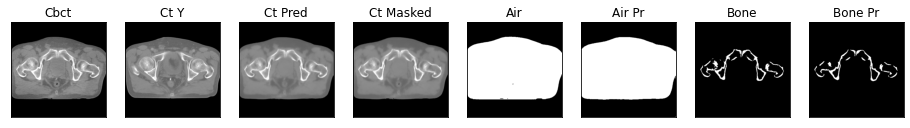

ssim score = 0.7554512023925781
psnr score = 20.71050262451172
snr score = 12.786202430725098
mae error = 0.041770558804273605
air dice score = 0.996503315821206
bone dice score = 0.8609920391930905


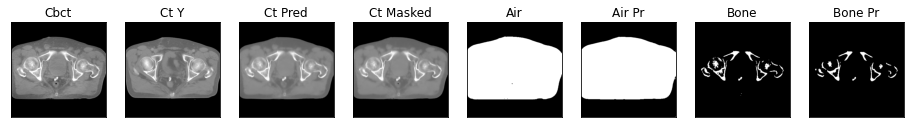

ssim score = 0.7667636275291443
psnr score = 20.88283920288086
snr score = 12.835453033447266
mae error = 0.04061983898282051
air dice score = 0.9965221690168393
bone dice score = 0.8164983165002472


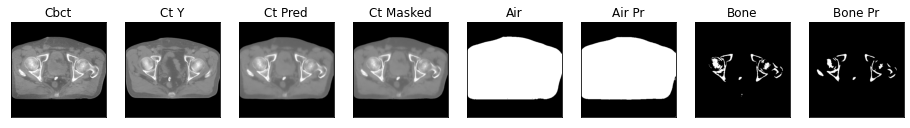

ssim score = 0.7707024216651917
psnr score = 21.171875
snr score = 13.012056350708008
mae error = 0.03891129046678543
air dice score = 0.9962045073634883
bone dice score = 0.8523234301898756


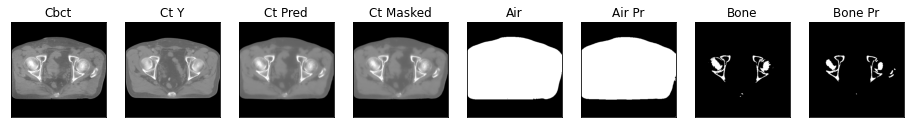

ssim score = 0.771212637424469
psnr score = 21.504379272460938
snr score = 13.293913841247559
mae error = 0.03605671599507332
air dice score = 0.9962564126265215
bone dice score = 0.8797647571348315


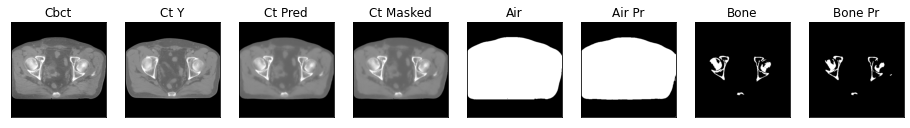

ssim score = 0.7695521712303162
psnr score = 21.31348419189453
snr score = 13.135173797607422
mae error = 0.037326276302337646
air dice score = 0.9960533864957456
bone dice score = 0.8807170765355008


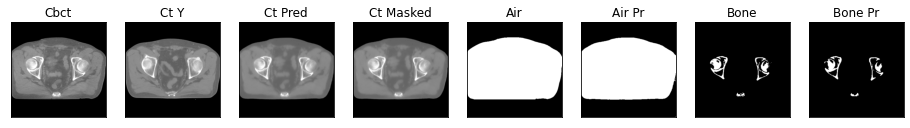

ssim score = 0.7699171304702759
psnr score = 21.11467170715332
snr score = 12.949837684631348
mae error = 0.03824452683329582
air dice score = 0.9962061260590284
bone dice score = 0.891353102418498


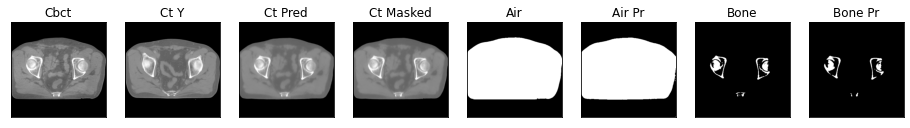

16it [00:39,  2.40s/it]

ssim score = 0.7678571939468384
psnr score = 20.717613220214844
snr score = 12.411288261413574
mae error = 0.03973616287112236
air dice score = 0.996006898769332
bone dice score = 0.920264582081536


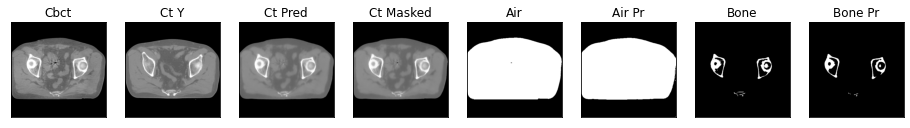

ssim score = 0.7770986557006836
psnr score = 20.892337799072266
snr score = 12.526704788208008
mae error = 0.03865642473101616
air dice score = 0.995813340859914
bone dice score = 0.9229478394640896


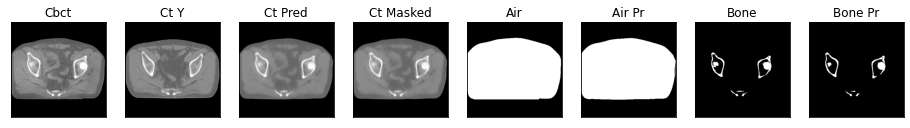

ssim score = 0.7780253291130066
psnr score = 21.26751136779785
snr score = 12.92752456665039
mae error = 0.03638920933008194
air dice score = 0.9956731962784785
bone dice score = 0.9068322981384543


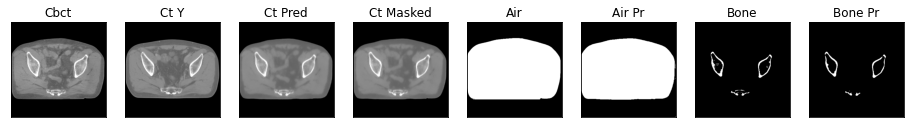

ssim score = 0.7755934000015259
psnr score = 21.261188507080078
snr score = 12.994017601013184
mae error = 0.03632102906703949
air dice score = 0.9952274820956315
bone dice score = 0.9162491052269819


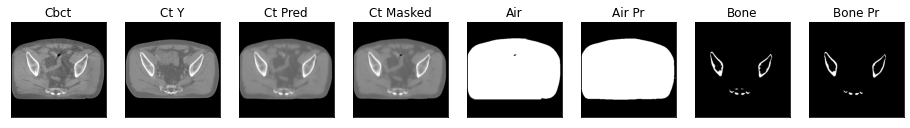

ssim score = 0.7693217992782593
psnr score = 21.035064697265625
snr score = 12.897123336791992
mae error = 0.03792960196733475
air dice score = 0.994503524913374
bone dice score = 0.9207986688865092


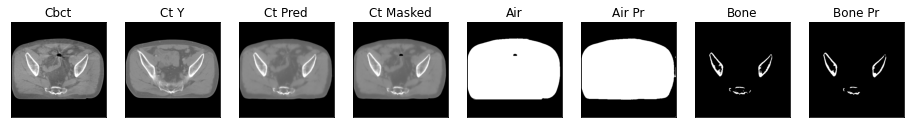

ssim score = 0.7615472674369812
psnr score = 20.941089630126953
snr score = 12.837106704711914
mae error = 0.03846771642565727
air dice score = 0.9946628842062274
bone dice score = 0.9091185873053872


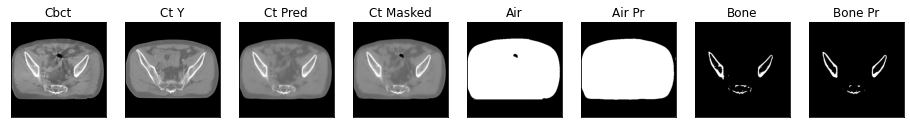

ssim score = 0.7489716410636902
psnr score = 20.732450485229492
snr score = 12.598678588867188
mae error = 0.0398203544318676
air dice score = 0.9953562425368212
bone dice score = 0.9026240517360699


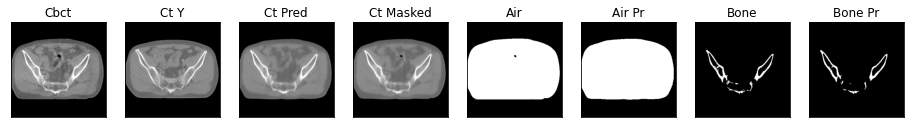

ssim score = 0.746724545955658
psnr score = 20.93167495727539
snr score = 12.734526634216309
mae error = 0.03885369747877121
air dice score = 0.9954908879621868
bone dice score = 0.9011194029863924


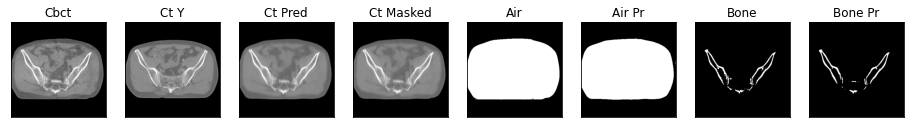

17it [00:41,  2.43s/it]

ssim score = 0.8645702004432678
psnr score = 24.413183212280273
snr score = 15.89057445526123
mae error = 0.022870592772960663
air dice score = 0.995675611634385
bone dice score = 0.8898444416353883


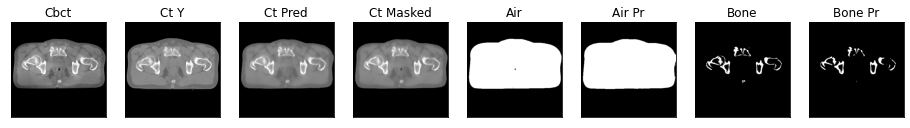

ssim score = 0.8659898638725281
psnr score = 24.59659767150879
snr score = 16.114004135131836
mae error = 0.02238871157169342
air dice score = 0.9955860206678124
bone dice score = 0.8782229274113682


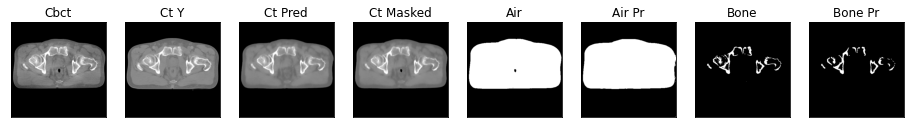

ssim score = 0.8654611110687256
psnr score = 24.751361846923828
snr score = 16.276552200317383
mae error = 0.022681765258312225
air dice score = 0.9955531799588758
bone dice score = 0.8415869442903547


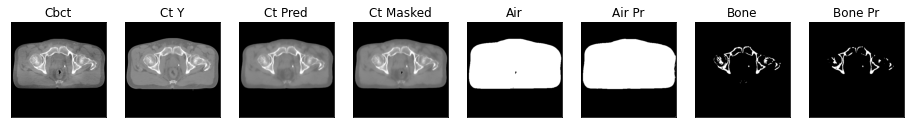

ssim score = 0.8692836761474609
psnr score = 24.836748123168945
snr score = 16.303518295288086
mae error = 0.021899687126278877
air dice score = 0.9951843278527497
bone dice score = 0.8423020429985004


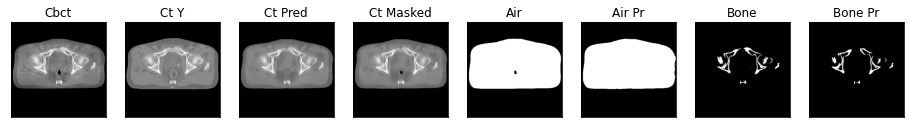

ssim score = 0.8738460540771484
psnr score = 25.00860595703125
snr score = 16.319751739501953
mae error = 0.020208382979035378
air dice score = 0.9950493201215679
bone dice score = 0.844074190508581


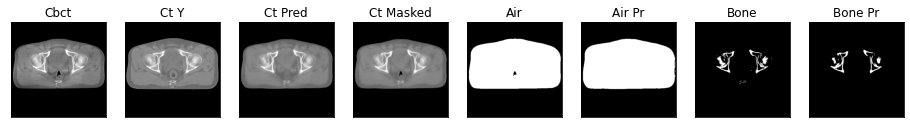

ssim score = 0.8776978850364685
psnr score = 25.124515533447266
snr score = 16.414859771728516
mae error = 0.019954433664679527
air dice score = 0.9955966930266029
bone dice score = 0.8809905316841807


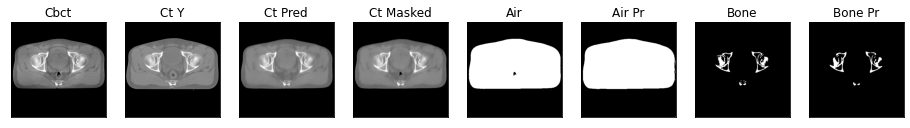

ssim score = 0.8791632056236267
psnr score = 25.17469024658203
snr score = 16.44940185546875
mae error = 0.01953923888504505
air dice score = 0.9957838252203941
bone dice score = 0.8865949820804789


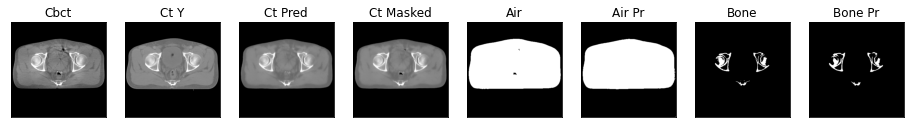

ssim score = 0.8755922913551331
psnr score = 24.643035888671875
snr score = 15.92711067199707
mae error = 0.020433425903320312
air dice score = 0.9946140035906683
bone dice score = 0.8806404657950416


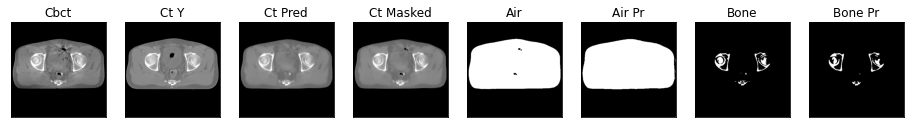

18it [00:44,  2.44s/it]

ssim score = 0.8730046153068542
psnr score = 24.53689193725586
snr score = 15.876749992370605
mae error = 0.02127929963171482
air dice score = 0.995516373176876
bone dice score = 0.9157366071440327


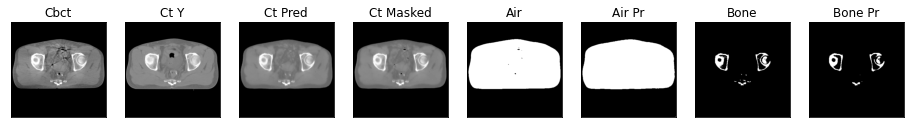

ssim score = 0.8699327111244202
psnr score = 23.891592025756836
snr score = 15.20952033996582
mae error = 0.022389212623238564
air dice score = 0.9951877827367435
bone dice score = 0.9166072701366129


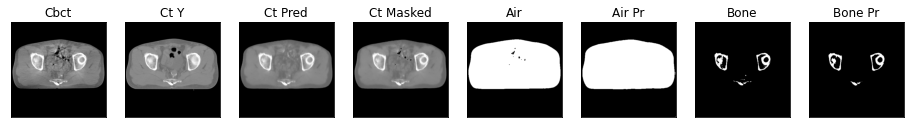

ssim score = 0.8704106211662292
psnr score = 23.50923728942871
snr score = 14.756393432617188
mae error = 0.02238781377673149
air dice score = 0.9944122169947819
bone dice score = 0.8795828580759396


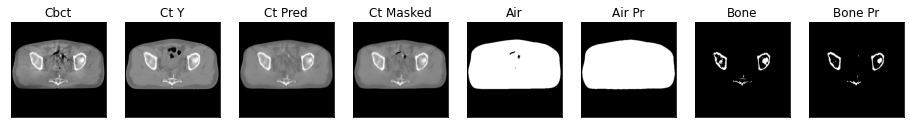

ssim score = 0.869404137134552
psnr score = 23.71272850036621
snr score = 14.91598892211914
mae error = 0.02221950702369213
air dice score = 0.9958943207313941
bone dice score = 0.8885470085489138


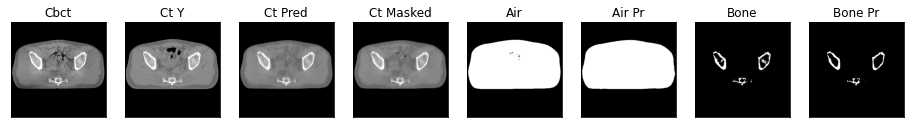

ssim score = 0.87232905626297
psnr score = 24.158992767333984
snr score = 15.361156463623047
mae error = 0.021405251696705818
air dice score = 0.9952777118715451
bone dice score = 0.911067193677354


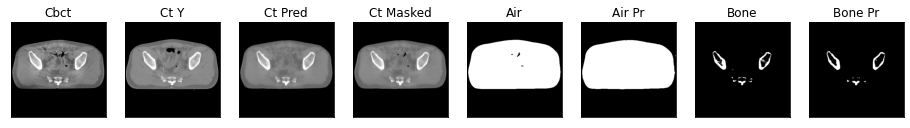

ssim score = 0.8703745603561401
psnr score = 24.52920913696289
snr score = 15.744729042053223
mae error = 0.021103667095303535
air dice score = 0.9940628432298793
bone dice score = 0.9217527386553717


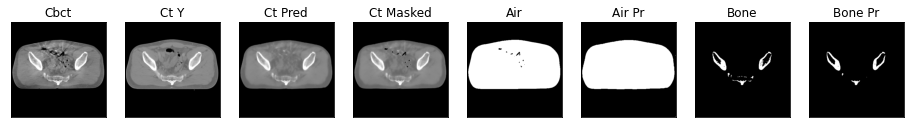

ssim score = 0.8689659833908081
psnr score = 24.85038948059082
snr score = 16.12111473083496
mae error = 0.020751751959323883
air dice score = 0.9926088062335797
bone dice score = 0.9242602007570817


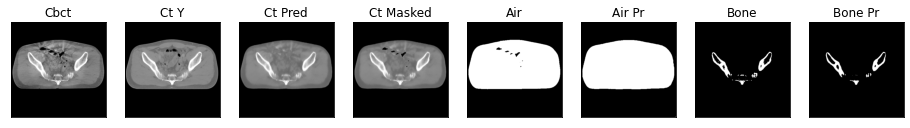

ssim score = 0.8682207465171814
psnr score = 24.25655746459961
snr score = 15.546655654907227
mae error = 0.02157791517674923
air dice score = 0.9927410885278366
bone dice score = 0.9218314532193519


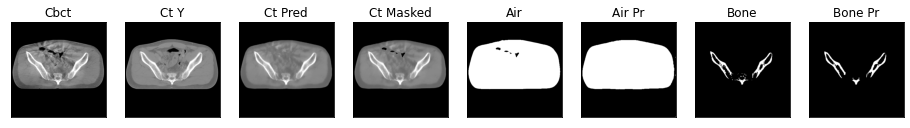

19it [00:46,  2.39s/it]

ssim score = 0.8711693286895752
psnr score = 23.849807739257812
snr score = 15.085164070129395
mae error = 0.021963665261864662
air dice score = 0.9939055004982242
bone dice score = 0.9080844865271946


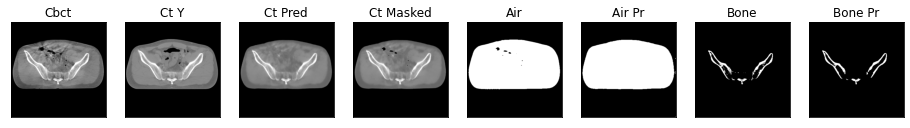

ssim score = 0.8704069256782532
psnr score = 23.702808380126953
snr score = 14.901810646057129
mae error = 0.022435108199715614
air dice score = 0.9948345989081557
bone dice score = 0.8897707231056765


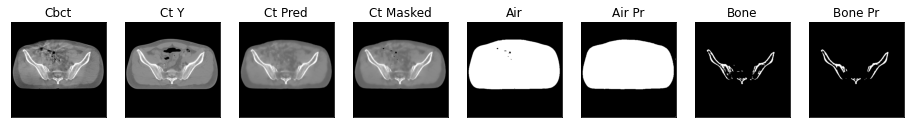

ssim score = 0.872626543045044
psnr score = 23.693788528442383
snr score = 14.892864227294922
mae error = 0.02245052345097065
air dice score = 0.9948890299998491
bone dice score = 0.8900370959209057


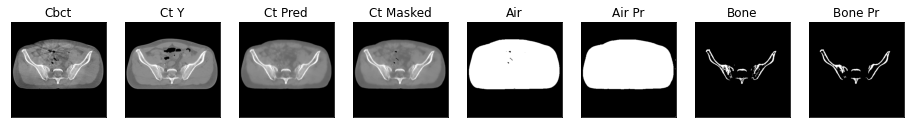

ssim score = 0.8732705116271973
psnr score = 24.142227172851562
snr score = 15.339881896972656
mae error = 0.02182486280798912
air dice score = 0.9946396295060899
bone dice score = 0.8794212218665672


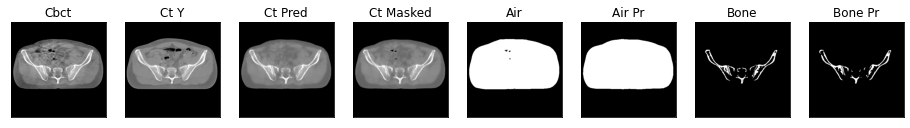

ssim score = 0.8652077913284302
psnr score = 23.7795352935791
snr score = 14.982227325439453
mae error = 0.02298644743859768
air dice score = 0.9936063967145329
bone dice score = 0.8771401177937661


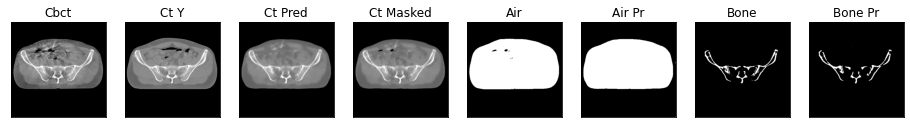

ssim score = 0.8645828366279602
psnr score = 23.642406463623047
snr score = 14.827827453613281
mae error = 0.02347736433148384
air dice score = 0.9926241267465128
bone dice score = 0.8713990351499462


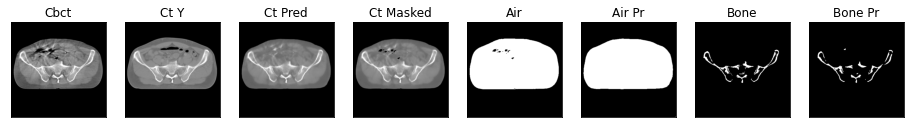

ssim score = 0.8577606678009033
psnr score = 23.069046020507812
snr score = 14.235840797424316
mae error = 0.02514367736876011
air dice score = 0.9916346477396398
bone dice score = 0.8550686378055034


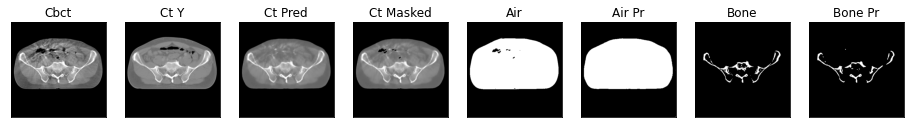

ssim score = 0.8493852019309998
psnr score = 22.672637939453125
snr score = 13.793496131896973
mae error = 0.026353836059570312
air dice score = 0.9912784079758282
bone dice score = 0.8413954091578084


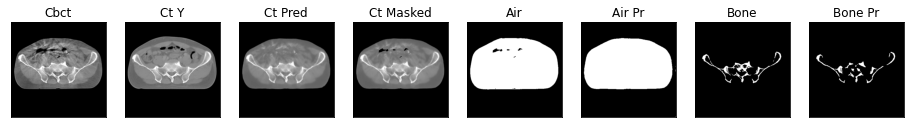

20it [00:48,  2.43s/it]

ssim score = 0.8443206548690796
psnr score = 22.80267906188965
snr score = 13.869741439819336
mae error = 0.02640816569328308
air dice score = 0.9907126596138619
bone dice score = 0.8758834469947193


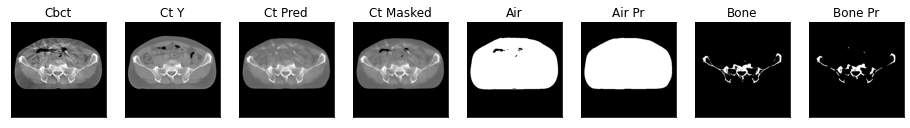

ssim score = 0.8396597504615784
psnr score = 22.515918731689453
snr score = 13.613443374633789
mae error = 0.027682986110448837
air dice score = 0.9890858511218503
bone dice score = 0.8910985983000945


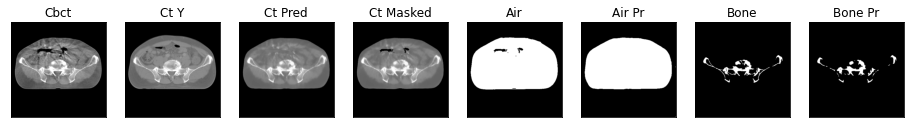

ssim score = 0.8344058990478516
psnr score = 21.978139877319336
snr score = 13.020439147949219
mae error = 0.02851981855928898
air dice score = 0.9892536177901846
bone dice score = 0.8727684184074331


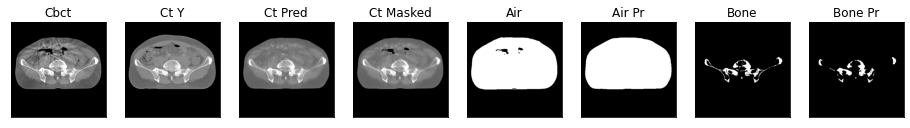

ssim score = 0.8429388999938965
psnr score = 22.66164779663086
snr score = 13.556413650512695
mae error = 0.02624560333788395
air dice score = 0.9892124620688645
bone dice score = 0.8935614470433125


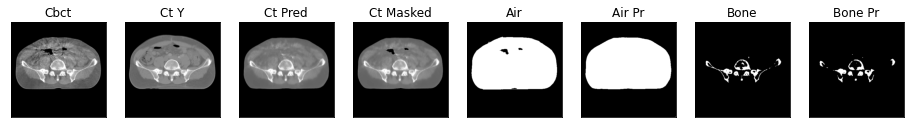

ssim score = 0.8895696401596069
psnr score = 26.88767433166504
snr score = 17.268587112426758
mae error = 0.015489893034100533
air dice score = 0.994179964343077
bone dice score = 0.952303079859572


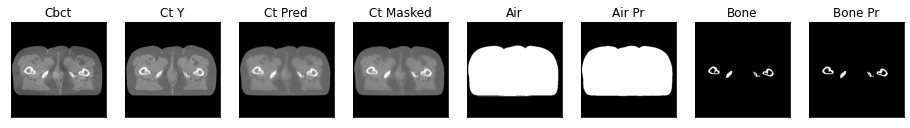

ssim score = 0.8905808925628662
psnr score = 27.10234832763672
snr score = 17.604272842407227
mae error = 0.015348494052886963
air dice score = 0.9948904895760169
bone dice score = 0.9543778801853829


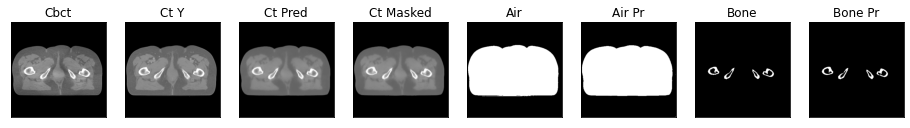

ssim score = 0.8870049715042114
psnr score = 27.038082122802734
snr score = 17.6229248046875
mae error = 0.01571374386548996
air dice score = 0.9951988826490563
bone dice score = 0.9378507586793213


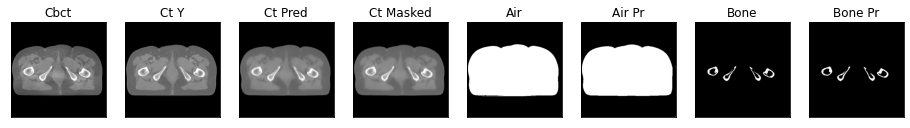

ssim score = 0.8842293620109558
psnr score = 26.990373611450195
snr score = 17.63865852355957
mae error = 0.015875194221735
air dice score = 0.9951216687656554
bone dice score = 0.9388670779596398


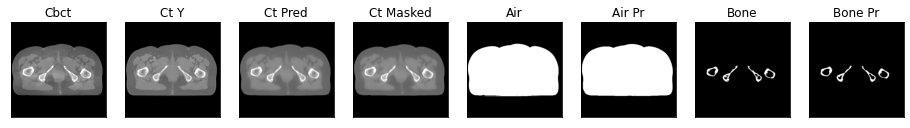

21it [00:51,  2.45s/it]

ssim score = 0.8845023512840271
psnr score = 26.85784339904785
snr score = 17.534591674804688
mae error = 0.016105670481920242
air dice score = 0.9952625089233599
bone dice score = 0.9462670686301424


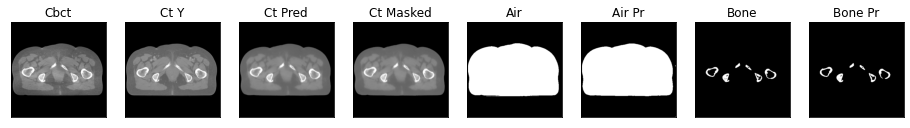

ssim score = 0.8844609260559082
psnr score = 26.670581817626953
snr score = 17.370285034179688
mae error = 0.0162383820861578
air dice score = 0.9950428445007267
bone dice score = 0.9375000000011557


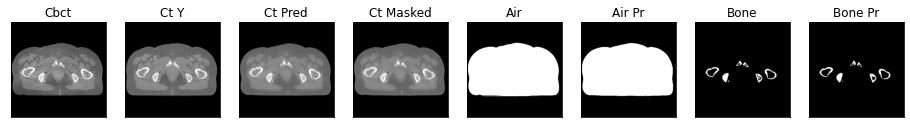

ssim score = 0.8801525235176086
psnr score = 26.442575454711914
snr score = 17.173603057861328
mae error = 0.016713278368115425
air dice score = 0.9950324470223432
bone dice score = 0.9383972378713721


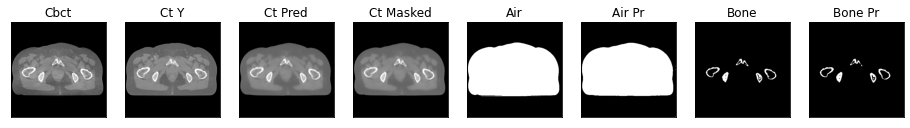

ssim score = 0.8812242150306702
psnr score = 26.451406478881836
snr score = 17.230798721313477
mae error = 0.01712706871330738
air dice score = 0.9947977872681971
bone dice score = 0.9319164265141946


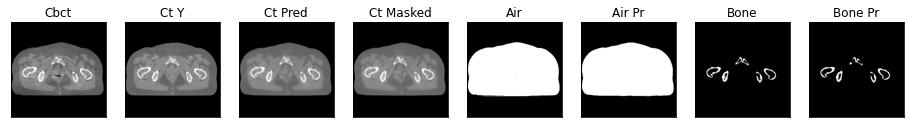

ssim score = 0.8833605647087097
psnr score = 26.460731506347656
snr score = 17.282869338989258
mae error = 0.016879728063941002
air dice score = 0.9941446703599959
bone dice score = 0.9289891395166417


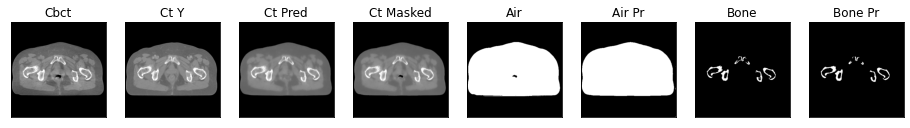

ssim score = 0.8820739388465881
psnr score = 26.70970916748047
snr score = 17.619550704956055
mae error = 0.016791926696896553
air dice score = 0.9932461951656271
bone dice score = 0.9069562665114916


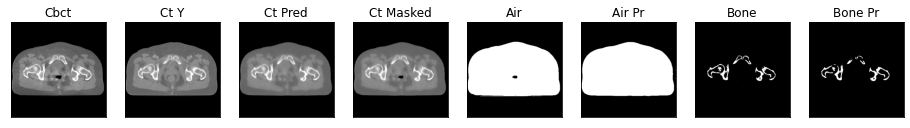

ssim score = 0.8825609087944031
psnr score = 27.008819580078125
snr score = 18.03193473815918
mae error = 0.01668158918619156
air dice score = 0.9940049673128023
bone dice score = 0.9158810732424959


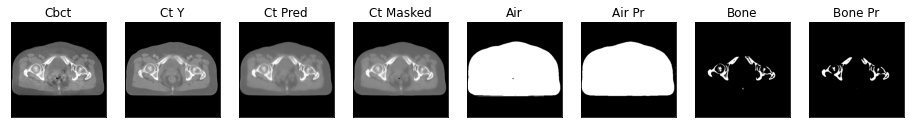

ssim score = 0.886307954788208
psnr score = 27.381380081176758
snr score = 18.27593994140625
mae error = 0.016160784289240837
air dice score = 0.9918055020200781
bone dice score = 0.8839017494277451


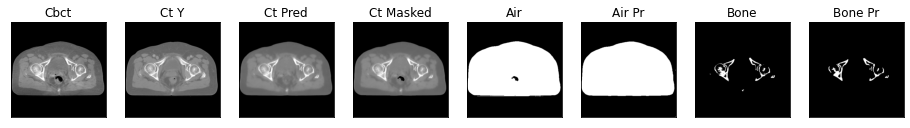

22it [00:53,  2.41s/it]

ssim score = 0.887680172920227
psnr score = 27.779844284057617
snr score = 18.564983367919922
mae error = 0.01570429839193821
air dice score = 0.9915905300816776
bone dice score = 0.8744038155827821


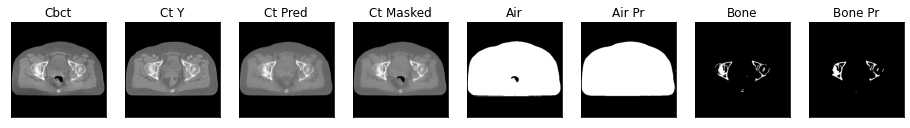

ssim score = 0.8895972967147827
psnr score = 27.580984115600586
snr score = 18.3389949798584
mae error = 0.016412358731031418
air dice score = 0.9917765379011395
bone dice score = 0.8957120169420203


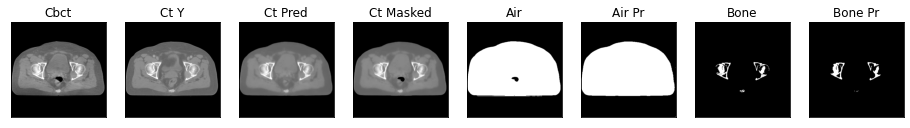

ssim score = 0.8905759453773499
psnr score = 27.3012638092041
snr score = 18.051271438598633
mae error = 0.017099587246775627
air dice score = 0.9936484636339301
bone dice score = 0.9044953350313063


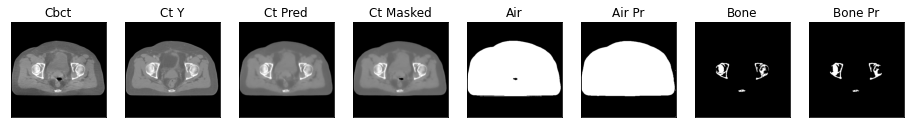

ssim score = 0.8895177245140076
psnr score = 27.53791046142578
snr score = 18.322145462036133
mae error = 0.016254175454378128
air dice score = 0.9942657097847055
bone dice score = 0.9302839116730239


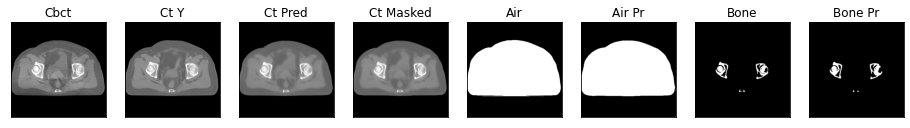

ssim score = 0.8842082023620605
psnr score = 27.01643180847168
snr score = 17.852161407470703
mae error = 0.016485536471009254
air dice score = 0.9947813518452926
bone dice score = 0.9456250000008496


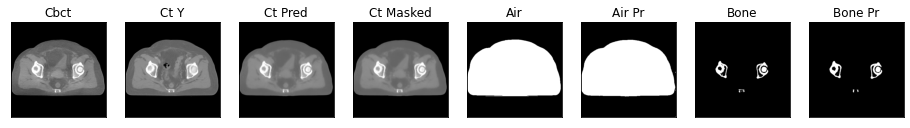

ssim score = 0.8734598755836487
psnr score = 25.92900848388672
snr score = 16.80229377746582
mae error = 0.01819935068488121
air dice score = 0.9947921689651883
bone dice score = 0.9496974935185878


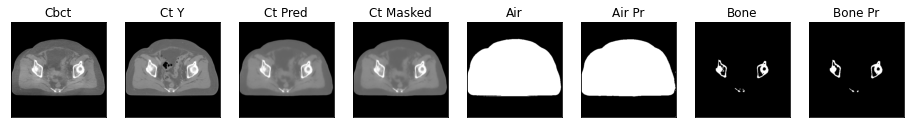

ssim score = 0.8607733249664307
psnr score = 24.472183227539062
snr score = 15.273036003112793
mae error = 0.020682677626609802
air dice score = 0.9947195485999667
bone dice score = 0.9324657841612639


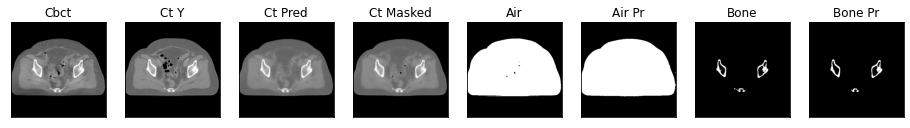

ssim score = 0.8592361211776733
psnr score = 24.449127197265625
snr score = 15.231983184814453
mae error = 0.0209556445479393
air dice score = 0.9935289569004154
bone dice score = 0.9378995433804133


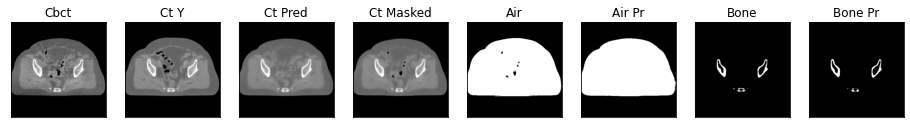

23it [00:56,  2.44s/it]

ssim score = 0.8582918643951416
psnr score = 24.897558212280273
snr score = 15.745330810546875
mae error = 0.02055930159986019
air dice score = 0.9941844847963938
bone dice score = 0.9369602763398757


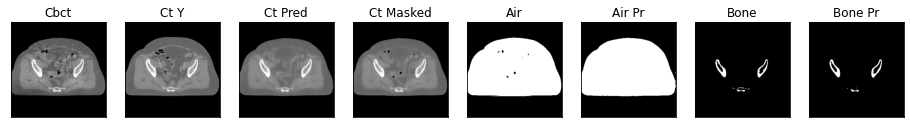

ssim score = 0.8585326075553894
psnr score = 24.684368133544922
snr score = 15.58723258972168
mae error = 0.02102084271609783
air dice score = 0.9941680869194756
bone dice score = 0.9400665926759144


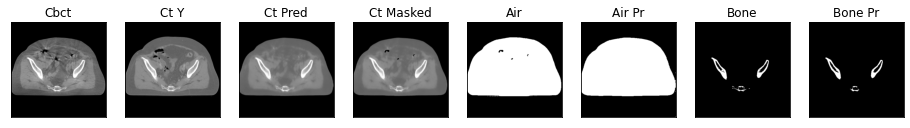

ssim score = 0.8543944358825684
psnr score = 24.23357391357422
snr score = 15.200870513916016
mae error = 0.022113442420959473
air dice score = 0.9946100001979228
bone dice score = 0.9353187529093328


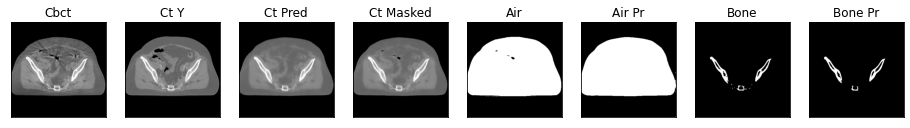

ssim score = 0.8554537892341614
psnr score = 24.356441497802734
snr score = 15.39659595489502
mae error = 0.02229732647538185
air dice score = 0.9941916747337889
bone dice score = 0.9015498154996081


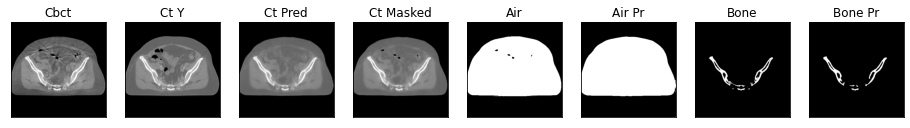

ssim score = 0.85381680727005
psnr score = 24.495731353759766
snr score = 15.531593322753906
mae error = 0.022372355684638023
air dice score = 0.9942609609161749
bone dice score = 0.907249779866345


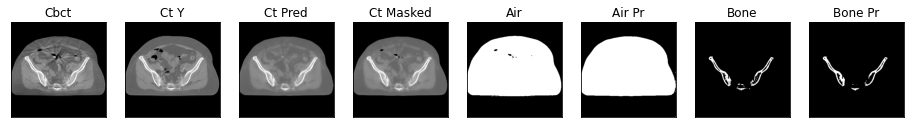

ssim score = 0.8513913750648499
psnr score = 24.22161293029785
snr score = 15.235300064086914
mae error = 0.0226838830858469
air dice score = 0.9947512639419586
bone dice score = 0.9051552264325669


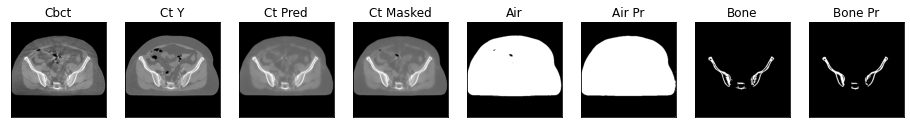

ssim score = 0.8530557751655579
psnr score = 24.683000564575195
snr score = 15.708321571350098
mae error = 0.022032316774129868
air dice score = 0.995437228387462
bone dice score = 0.9128704113237083


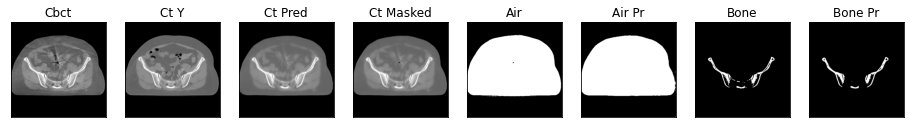

24it [00:58,  2.44s/it]


In [34]:
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [35]:
discriminator = Model(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)

In [36]:
discriminator.load_state_dict(checkpoint["dicriminator"])

<All keys matched successfully>

In [37]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test, score_acc_test 
# unmasked
eval_epoch(model, discriminator, testloader, device)

24it [00:05,  4.26it/s]


(0.8591085225343704,
 24.445002635320026,
 15.459572593371073,
 0.022995242499746382,
 0.9939540793566447,
 0.9129712850977337,
 0.5)

In [38]:
# import torchvision.models as models
# models.vgg16(pretrained=True)